# 연구과제 풀이

## #01. 패키지 가져오기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

# Intel SKlearn 하드웨어 가속 패치 설정
import sys
if sys.platform == 'win32':
    from sklearnex import patch_sklearn
    patch_sklearn()

from helper.util import *
from helper.plot import *
from helper.analysis import *
from helper.classification import *
from helper.re import *

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hyk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## #02. 위스콘신 유방암 데이터 셋

### [1] 데이터 가져오기

In [16]:
origin = my_read_excel("https://data.hossam.kr/mldata/breast-cancer-wisconsin.xlsx", index_col="id", categories=["diagnosis"], info=False)

### [2] 데이터 전처리

1. 종속변수 라벨링
2. 데이터 분할 + 데이터 스케일링
3. 데이터 불균형 해소 (SMOTE)

In [17]:
df1 = my_labelling(origin, 'diagnosis')

x_train, x_test, y_train, y_test = my_train_test_split(df1, 'diagnosis', scalling=True)

xdata, ydata = my_balance(x_train, y_train, method="smote")

### [3] 나이브베이즈 분류

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  0 |           1e-09 |          0.931362 |
|  1 |           1e-08 |          0.931362 |
|  2 |           1e-07 |          0.931362 |
|  3 |           1e-06 |          0.931362 |
|  4 |           1e-05 |          0.931362 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |      0.93662 |      0.95614 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.969697 |            1 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

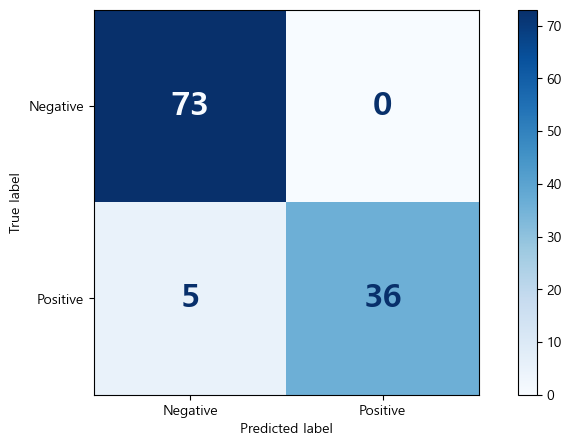

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


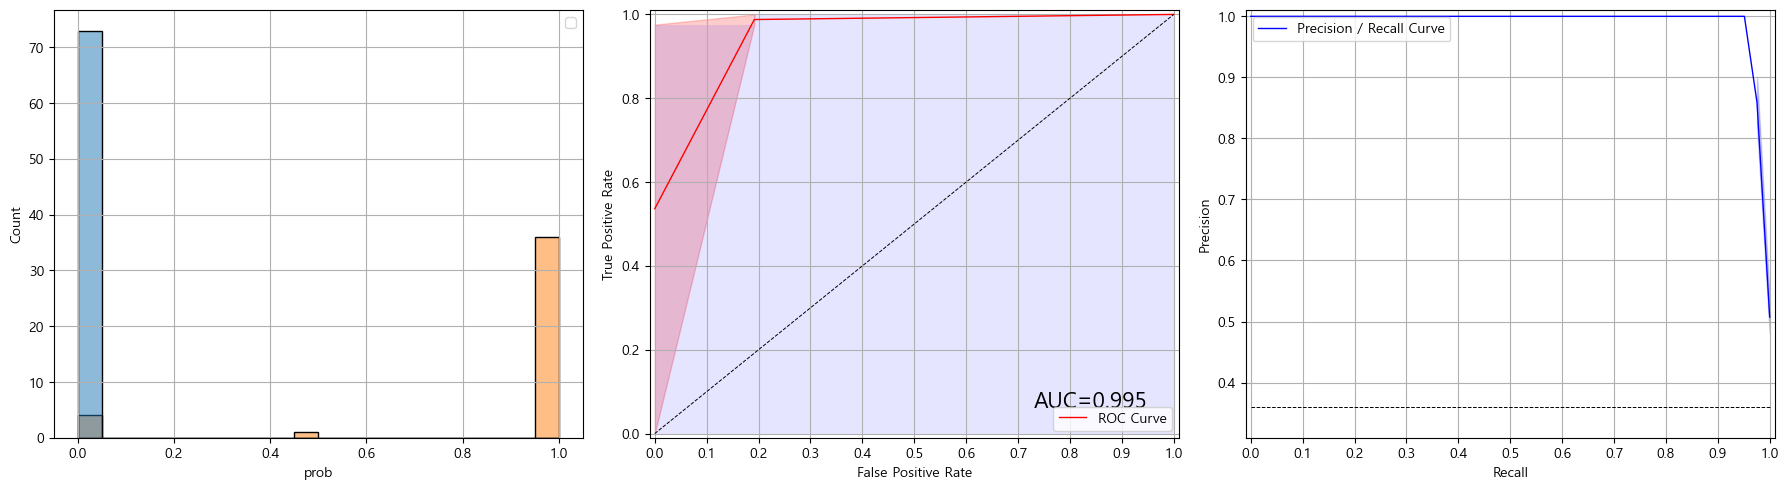


[학습곡선]


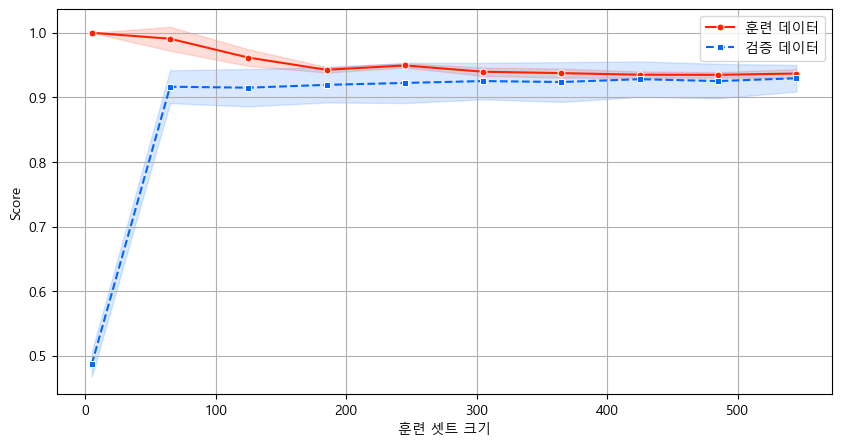

CPU times: total: 1.03 s
Wall time: 1.2 s


GaussianNB()

In [18]:
%%time
my_nb_classification(xdata, ydata, x_test, y_test)

### [4] 전체 성능 비교

In [19]:
%%time
my_classification(xdata, ydata, x_test, y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |            0.95614 |                   1 |         0.878049 |                   0 |             1 |   0.935065 | 0.995322 |
| KNeighborsClassifier |                         0 |           0.973684 |               0.975 |          0.95122 |           0.0136986 |      0.986301 |   0.962963 | 0.985633 |
| LogisticRegression   |                  0.883673 |           0.991228 |      

## #03. 타이타닉 생존률 예측

### [1] 데이터 가져오기

In [20]:
origin = my_read_excel("https://data.hossam.kr/edadata/titanic.xlsx", index_col='PassengerId', categories=['Survived', 'Pclass', 'Sex', 'Embarked'], info=False)

### [2] 데이터 전처리

1. 생존 여부에 따른 평균 나이로 결측치 치환
2. 히스토그램 구간에 따라 나이를 명목형으로 변환
3. 객실 유무에 따른 명목형 변수 생성
4. 가족 구성원 수 파생변수 생성
5. 혼자 탑승했는지에 대한 파생변수 생성
6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
8. 이름으로부터 호칭 파생변수 생성
9. 데이터 라벨링
10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
11. 불필요한 컬럼 제거
12. 훈련/검증 데이터 분리

In [21]:
df = origin.copy()

# 1. 생존 여부에 따른 평균 나이로 결측치 치환
mean_age_df = df[['Survived','Age']].groupby('Survived').mean()

for i in mean_age_df.index:
    mean_age = round(mean_age_df.loc[i]['Age'], 0)
    expr = (df['Survived'] == i) & (df['Age'].isna())
    df.loc[expr, 'Age'] = df.loc[expr, 'Age'].fillna(mean_age)

# 2. 히스토그램 구간에 따라 나이를 명목형으로 변환
hist, bins = np.histogram(df['Age'], bins=5)

df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

# 3. 객실 유무에 따른 명목형 변수 생성
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x:  0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

# 4. 가족 구성원 수 파생변수 생성
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1

# 5. 혼자 탑승했는지에 대한 파생변수 생성
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

# 6. 생존 여부에 따른 탑승지 최빈값으로 결측치 치환
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(Series.mode)

for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

# 7. 생존 여부에 따른 운임요금 평균으로 결측치 치환
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()

for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

# 8. 이름으로부터 호칭 파생변수 생성
df2['Title'] = df2['Name'].apply(get_title)

# 9. 데이터 라벨링
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')

# 10. 운임요금 사분위수 구간에 따른 명목형 파생변수 생성
df3.loc[ df3['Fare'] <= 7.9, "Fare"] = 0
df3.loc[ (df2['Fare'] > 7.9) & (df3['Fare'] <= 14.5), "Fare"] = 1
df3.loc[ (df3['Fare'] > 14.5) & (df3['Fare'] <= 31.3), "Fare"] = 2
df3.loc[ df3['Fare'] > 31.3, "Fare"] = 3

# 11. 불필요한 컬럼 제거
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

# 12. 훈련/검증 데이터 분리
df4['Survived'] = df4['Survived'].astype('int')
x_train, x_test, y_train, y_test = my_train_test_split(df4, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1047, 9), (262, 9), (1047,), (262,))

### [3] 나이브베이즈 분류

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  0 |           1e-09 |          0.812791 |
|  1 |           1e-08 |          0.812791 |
|  2 |           1e-07 |          0.812791 |
|  3 |           1e-06 |          0.812791 |
|  4 |           1e-05 |          0.812791 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.817574 |     0.816794 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.713389 |     0.694656 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

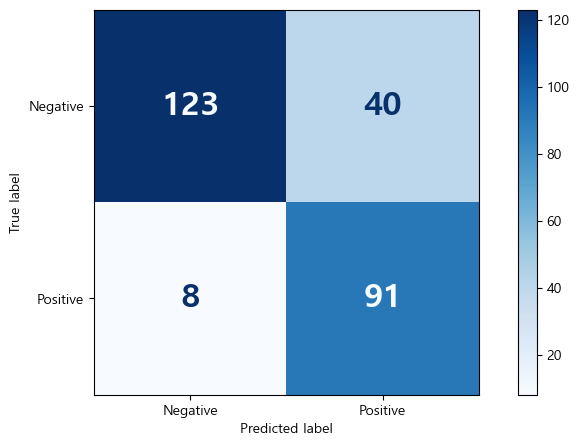

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


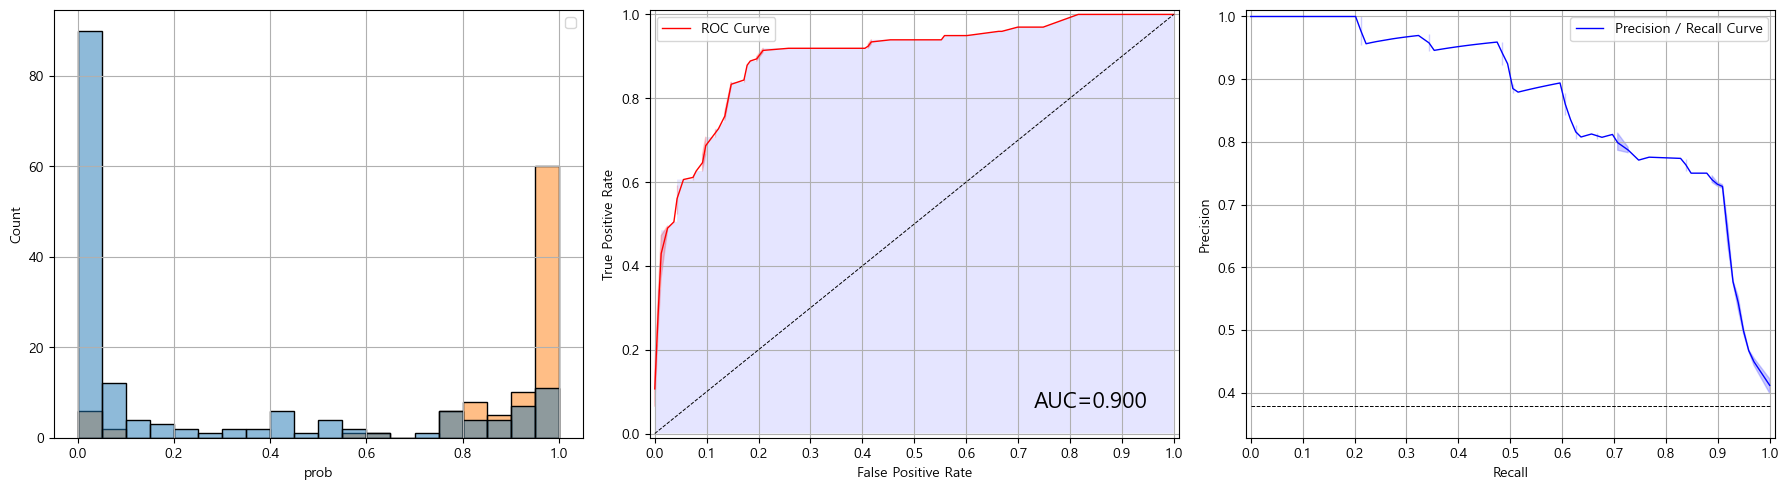

CPU times: total: 1.27 s
Wall time: 1.27 s


GaussianNB()

In [22]:
%%time
my_nb_classification(x_train, y_train, x_test, y_test, learning_curve=False)

### [4] 전체 성능 비교

In [23]:
%%time
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |           0.816794 |            0.694656 |         0.919192 |            0.245399 |      0.754601 |   0.791304 | 0.899672 |
| LogisticRegression   |                  0.478713 |           0.866412 |            0.826531 |         0.818182 |            0.104294 |      0.895706 |   0.822335 | 0.919502 |
| KNeighborsClassifier |                         0 |           0.870229 |      

## #04. 사과의 품질 분류

### [1] 데이터 가져오기

In [24]:
origin = my_read_excel("https://data.hossam.kr/mldata/apple_quality.xlsx", index_col='A_id', categories=['Quality'], info=False)

### [2] 데이터 전처리

1. 불필요한 행 제거
2. 종속변수 라벨링
3. 데이터 스케일링 + 훈련/검증 데이터 분리

In [25]:
df = origin.dropna()
df2 = my_labelling(df, 'Quality')
x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='Quality', scalling=True)

### [3] 나이브베이즈 분류

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
[교차검증 TOP5]
+----+-----------------+-------------------+
|    |   var_smoothing |   mean_test_score |
|----+-----------------+-------------------|
|  0 |           1e-09 |          0.751563 |
|  1 |           1e-08 |          0.751563 |
|  2 |           1e-07 |          0.751563 |
|  3 |           1e-06 |          0.751563 |
|  4 |           1e-05 |          0.751563 |
+----+-----------------+-------------------+

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.753125 |      0.71375 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |      0.75467 |     0.715762 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재

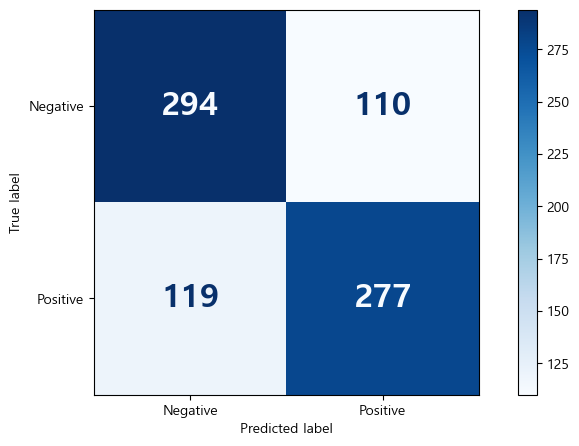

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



[Roc Curve]


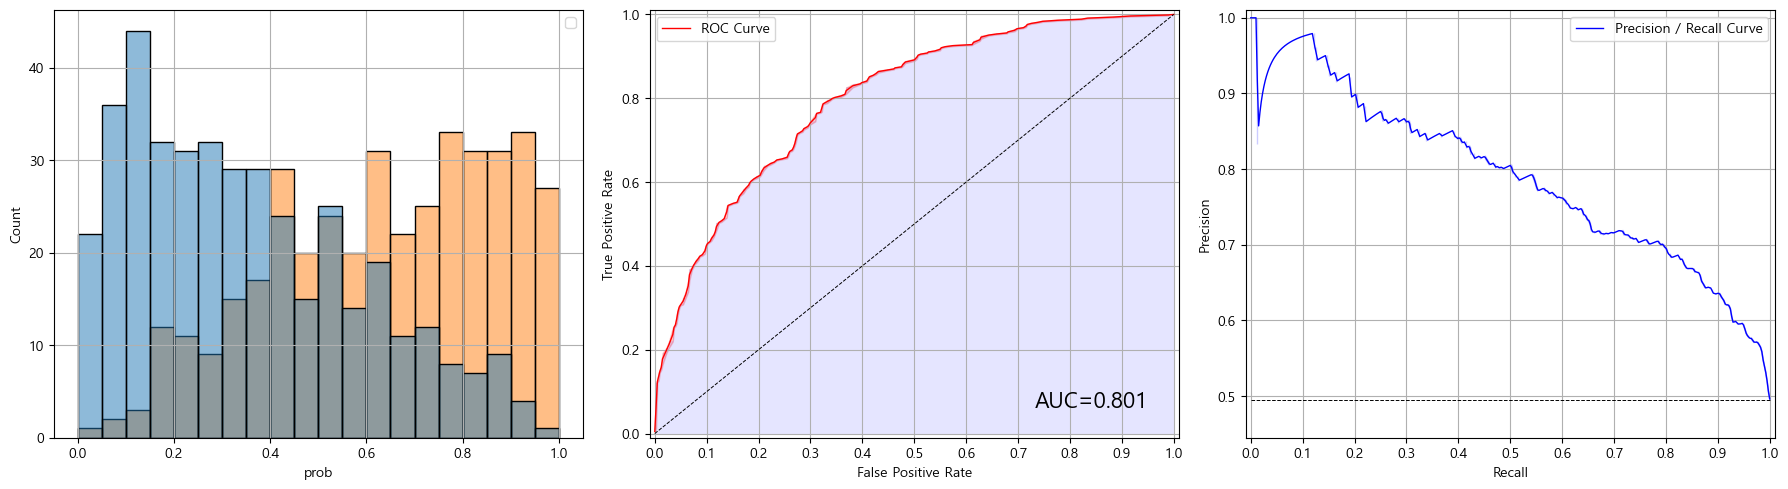


[학습곡선]


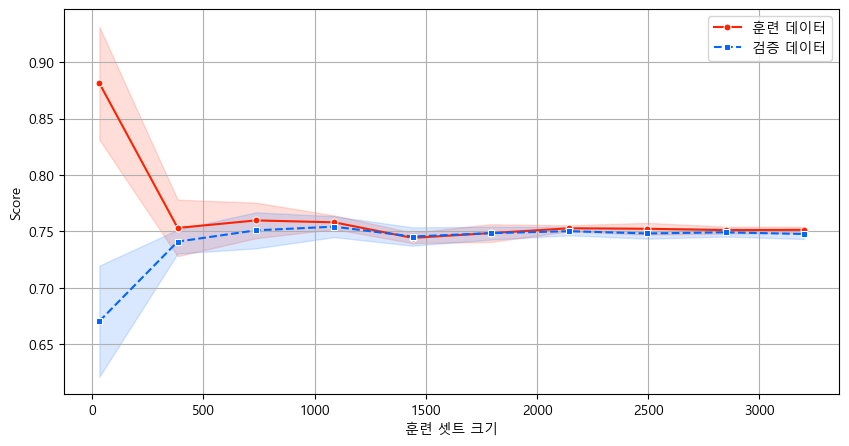

CPU times: total: 5.09 s
Wall time: 5.35 s


GaussianNB()

In [26]:
%%time
my_nb_classification(x_train, y_train, x_test, y_test)

### [4] 전체 성능 비교

In [27]:
%%time
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |            0.71375 |            0.715762 |         0.699495 |            0.272277 |      0.727723 |   0.707535 | 0.801093 |
| KNeighborsClassifier |                         0 |            0.90125 |            0.911688 |         0.886364 |           0.0841584 |      0.915842 |   0.898848 | 0.954517 |
| LogisticRegression   |                   0.21918 |            0.73625 |      

## #05. 버섯 데이터셋
아래의 데이터셋은 UCI Machine Learning 저장소에서 제공하는 버섯에 대한 데이터 셋이다.

이 데이터셋은 모든 변수에 대해 라벨링을 수행해야 한다.

이 데이터셋을 사용하여 식용 버섯과 독버섯을 구분할 수 있는 분류 모형을 구현하시오.

어떤 알고리즘을 사용하는 것이 가장 적합할지 결론을 제시하시오.

> https://data.hossam.kr/mldata/mushrooms.xlsx

> https://www.kaggle.com/datasets/uciml/mushroom-classification

| 변수 | 설명 |
|---|---|
| class | p-독성, e-식용 |
| cap-shape | 버섯의 모자 모양(bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s) |
| cap-surface | 버섯의 모자 표면(fibrous=f, grooves=g, scaly=y, smooth=s) |
| cap-color | 버섯의 모자 색상 |
| bruises | 버섯에 멍이 들었는지 여부(bruises=t, no=f) |
| odor | 버섯의 냄새 |
| gill-attachment | 버섯의 주름 부착 방식(attached=a, descending=d, free=f, notched=n). |
| gill-spacing | 주름 사이의 간격(close=c, crowded=w, distant=d) |
| gill-size | 주름 크기를 나타냅니다 (broad=b, narrow=n). |
| gill-color | 주름 색상 |
| stalk-shape | 줄기 모양(enlarging=e, tapering=t). |
| stalk-root | 줄기의 뿌리 부분 모양 |
| stalk-surface-above-ring | 반지 위의 줄기 표면 |
| stalk-surface-below-ring | 반지 아래의 줄기 표면 |
| stalk-color-above-ring | 반지 위의 줄기 색상 |
| stalk-color-below-ring | 반지 아래의 줄기 색상 |
| veil-type | 베일(버섯의 부속물)의 종류 |
| veil-color | 베일의 색상 |
| ring-number | 반지의 수(none=n, one=o, two=t). |
| ring-type | 반지의 종류 |
| spore-print-color | 포자 자국의 색상 |
| population | 개체군의 분포 형태 |
| habitat | 버섯이 자라는 환경 |

In [3]:
origin = my_read_data('https://data.hossam.kr/mldata/mushrooms.xlsx', save=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [44]:
df = my_labelling(origin.drop('veil-type',axis=1),'class',
 'cap-shape',
 'cap-surface',
 'cap-color',
 'bruises',
 'odor',
 'gill-attachment',
 'gill-spacing',
 'gill-size',
 'gill-color',
 'stalk-shape',
 'stalk-root',
 'stalk-surface-above-ring',
 'stalk-surface-below-ring',
 'stalk-color-above-ring',
 'stalk-color-below-ring',
 'veil-color',
 'ring-number',
 'ring-type',
 'spore-print-color',
 'population',
 'habitat')
df.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,2,7,7,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,2,7,7,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,2,7,7,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,2,7,7,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,2,7,7,2,1,0,3,0,1


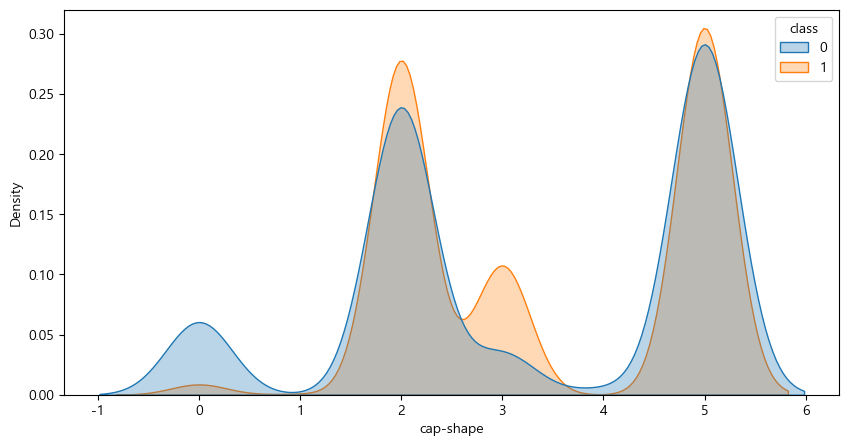

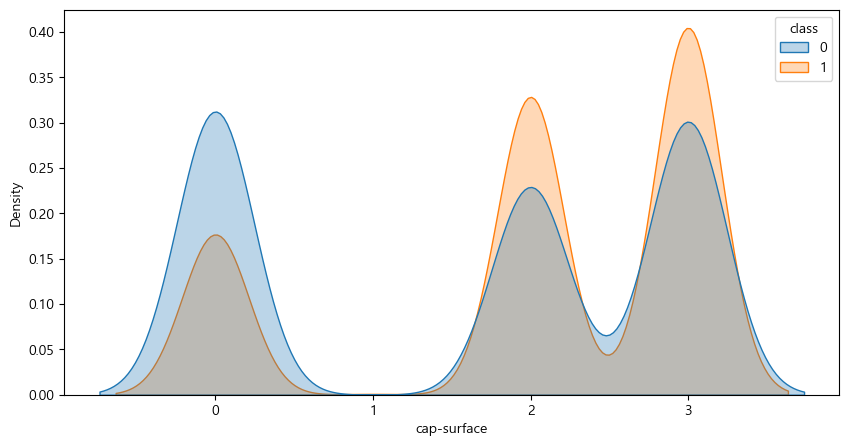

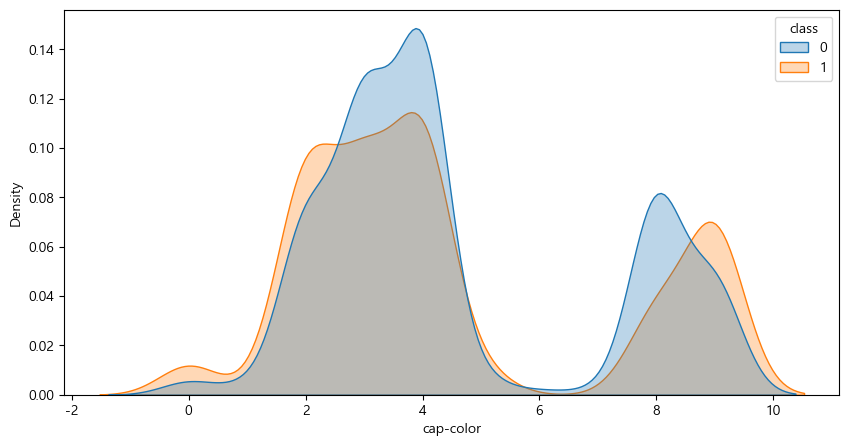

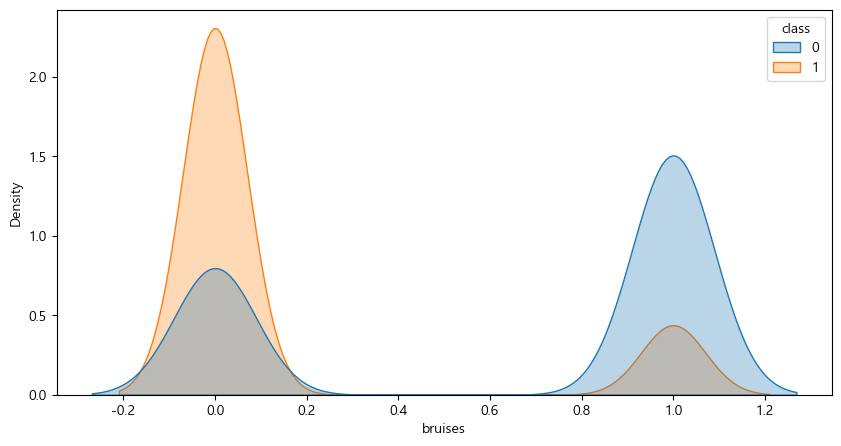

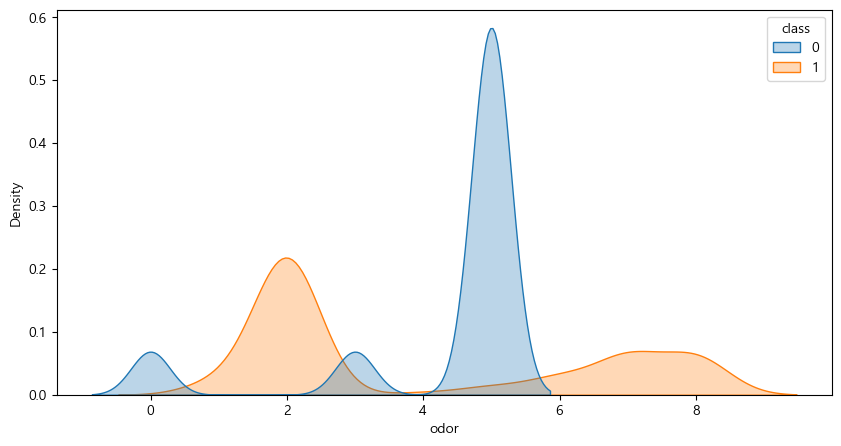

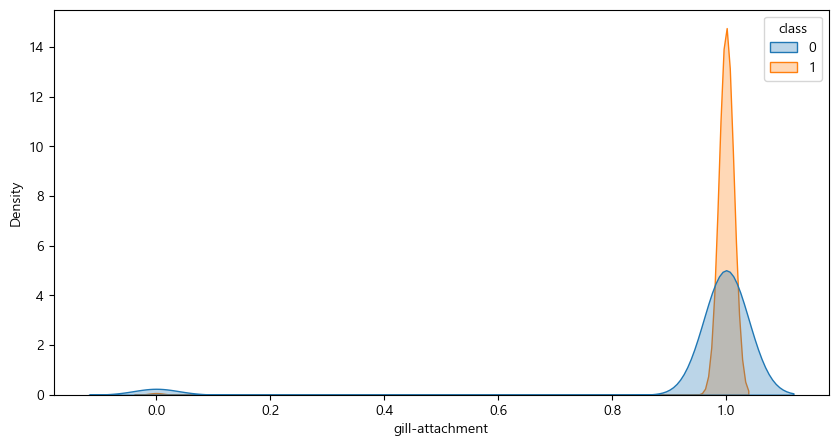

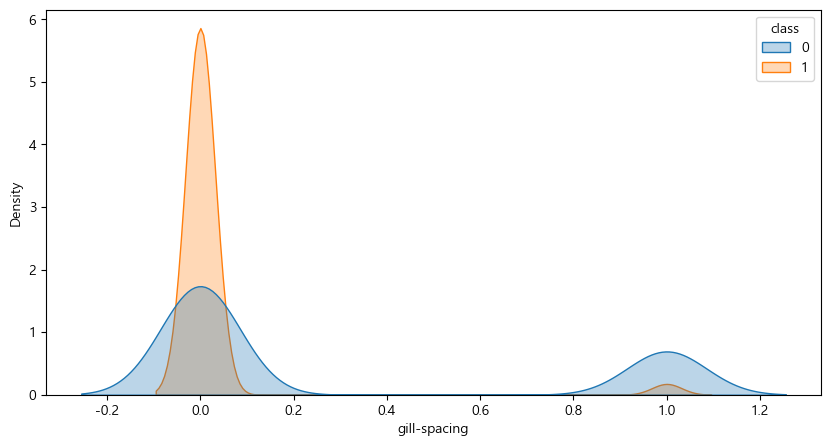

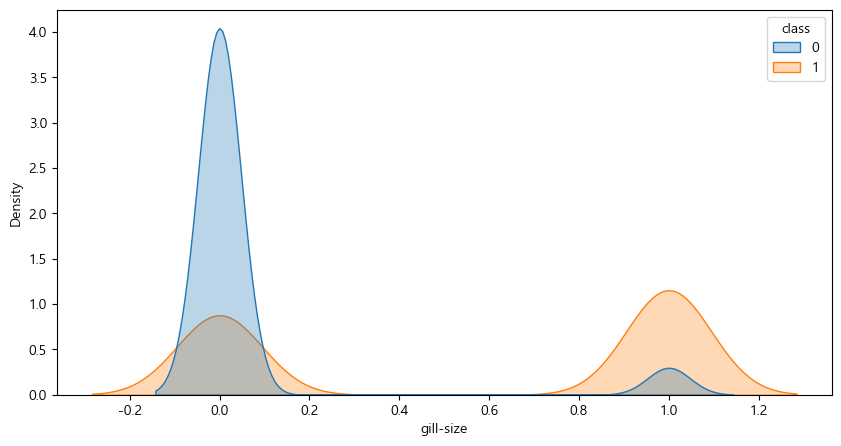

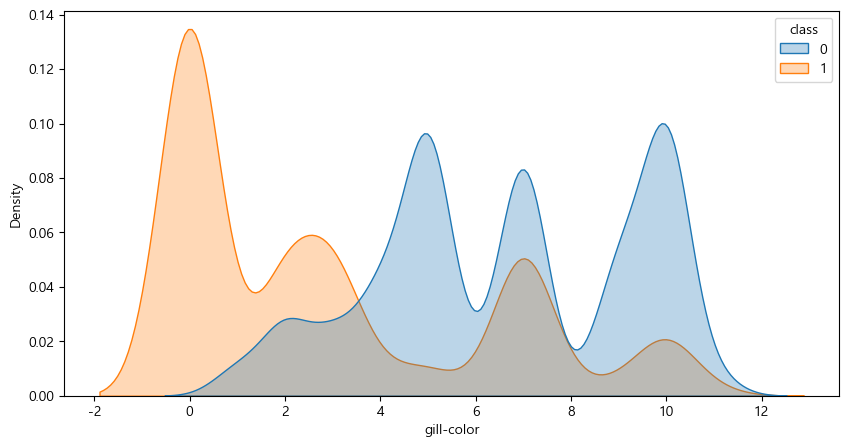

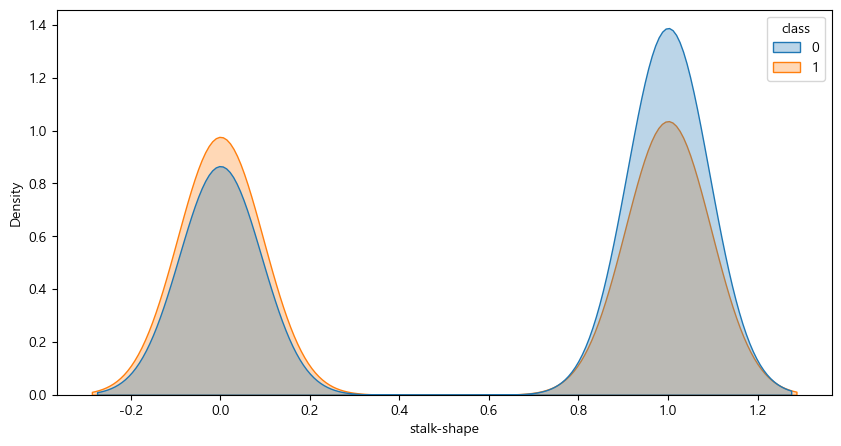

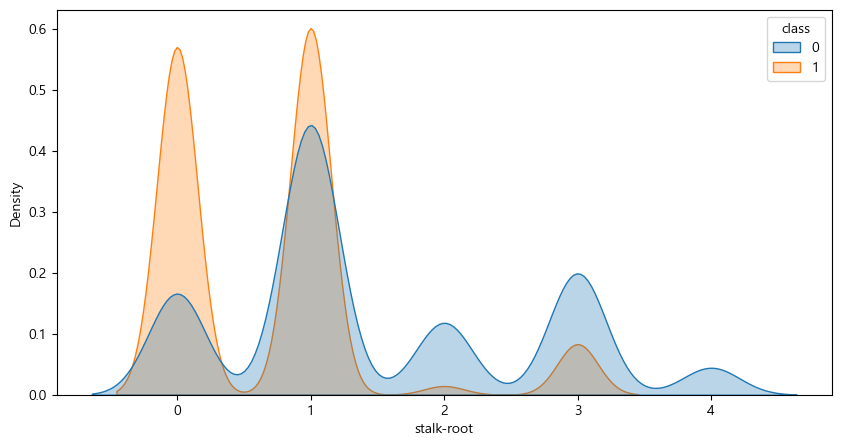

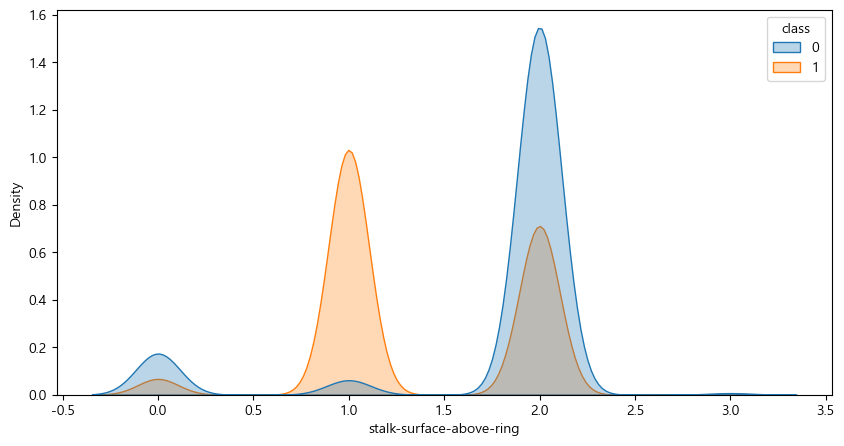

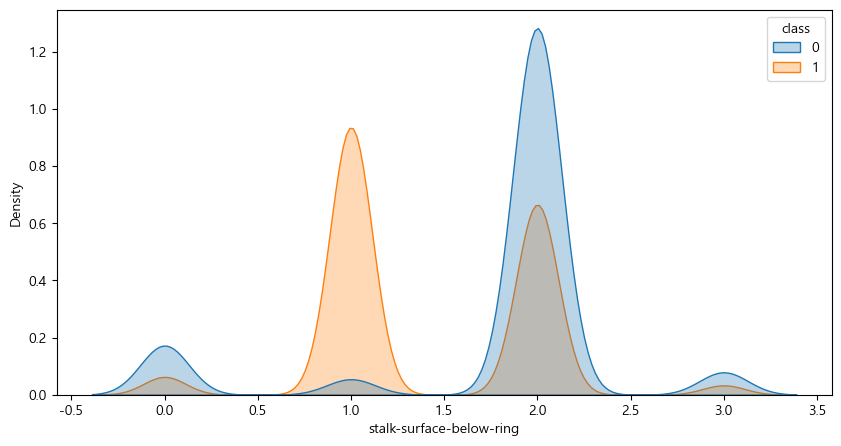

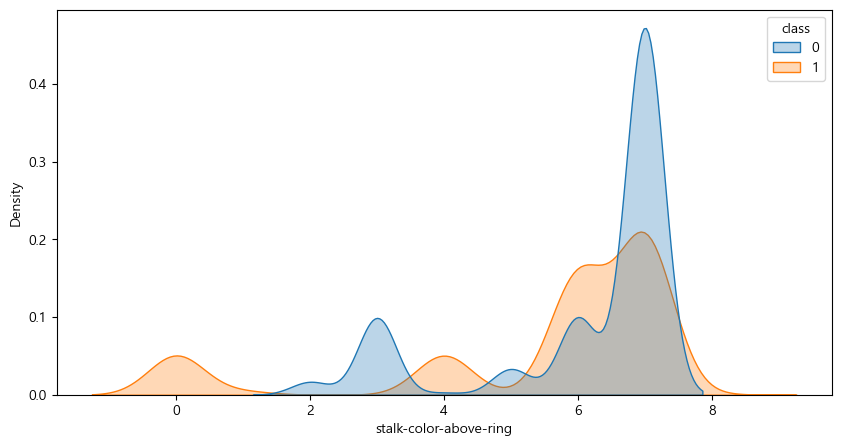

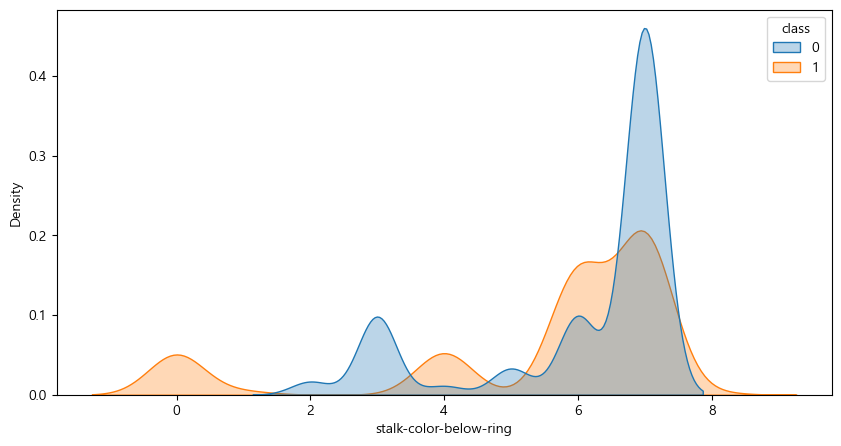

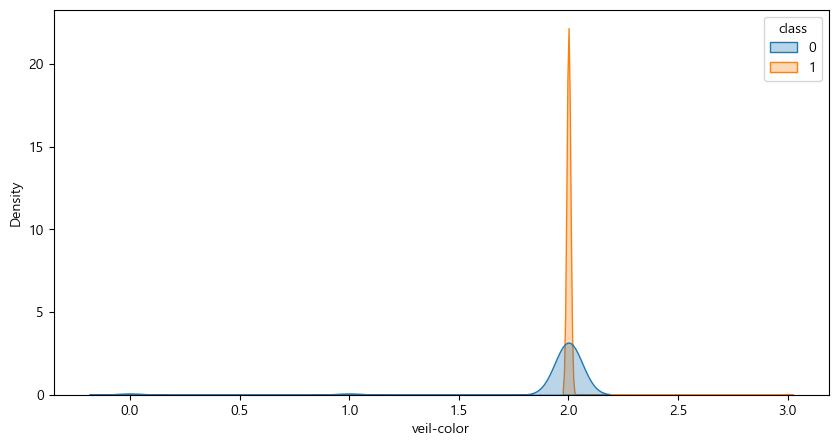

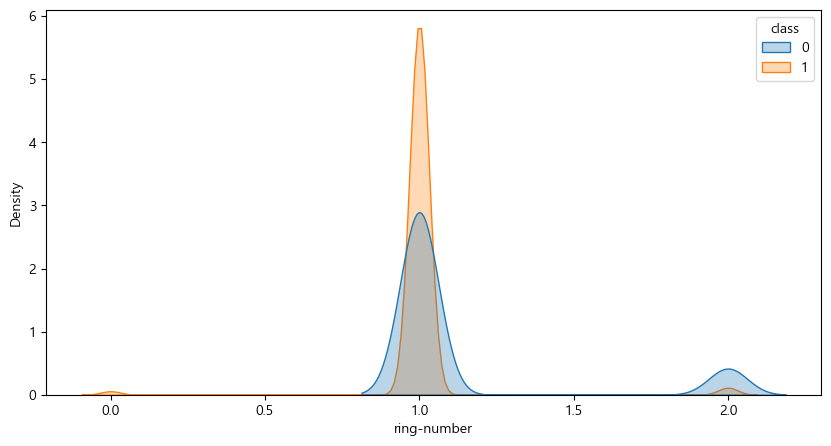

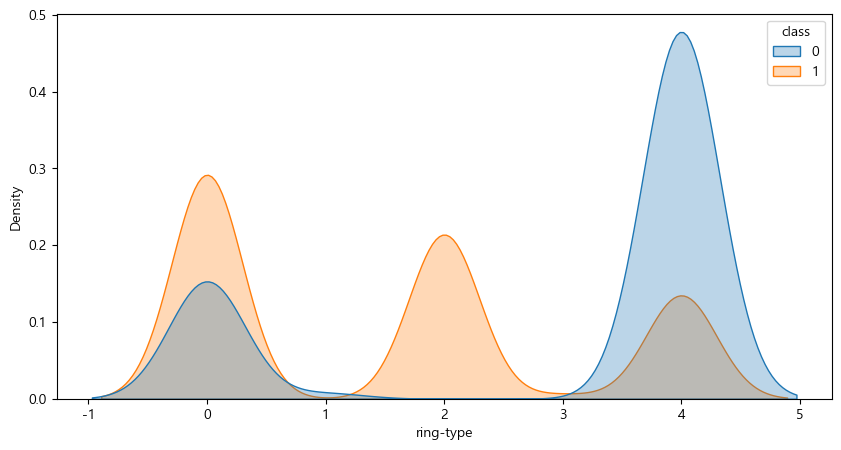

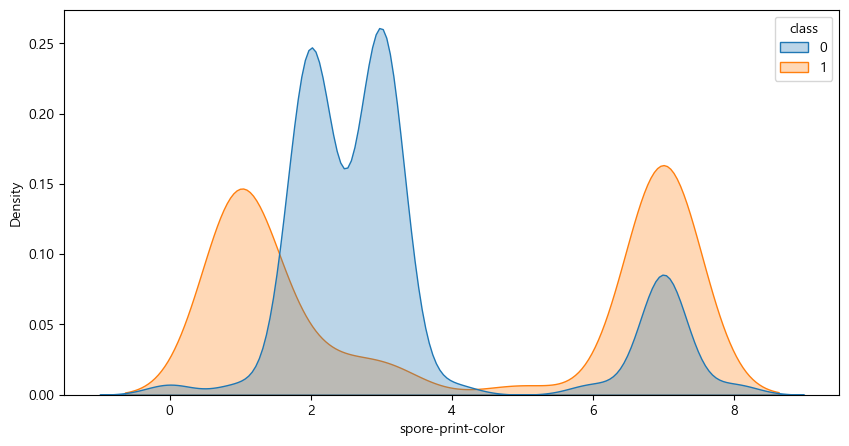

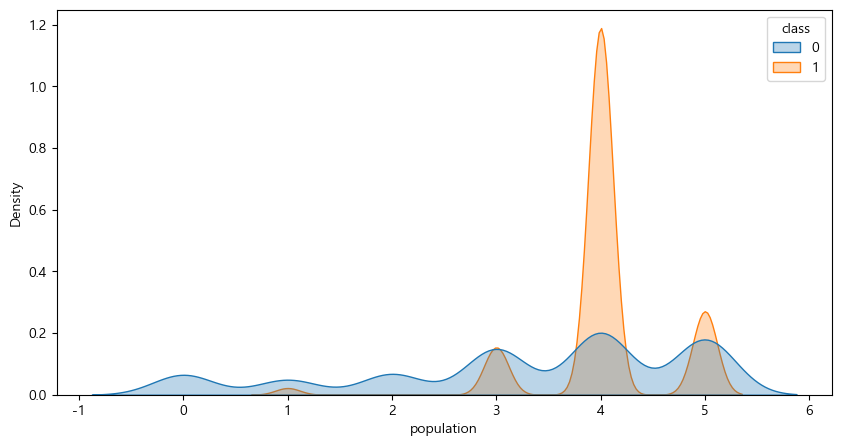

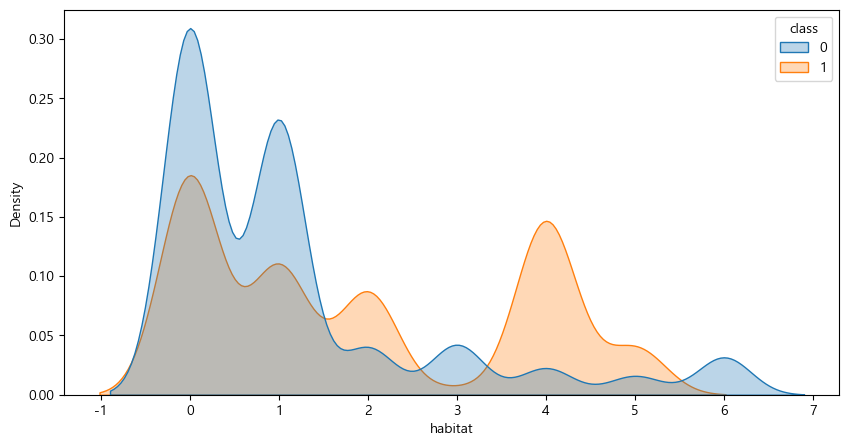

In [33]:
my_distribution_by_class(df,hue='class',fill=True)

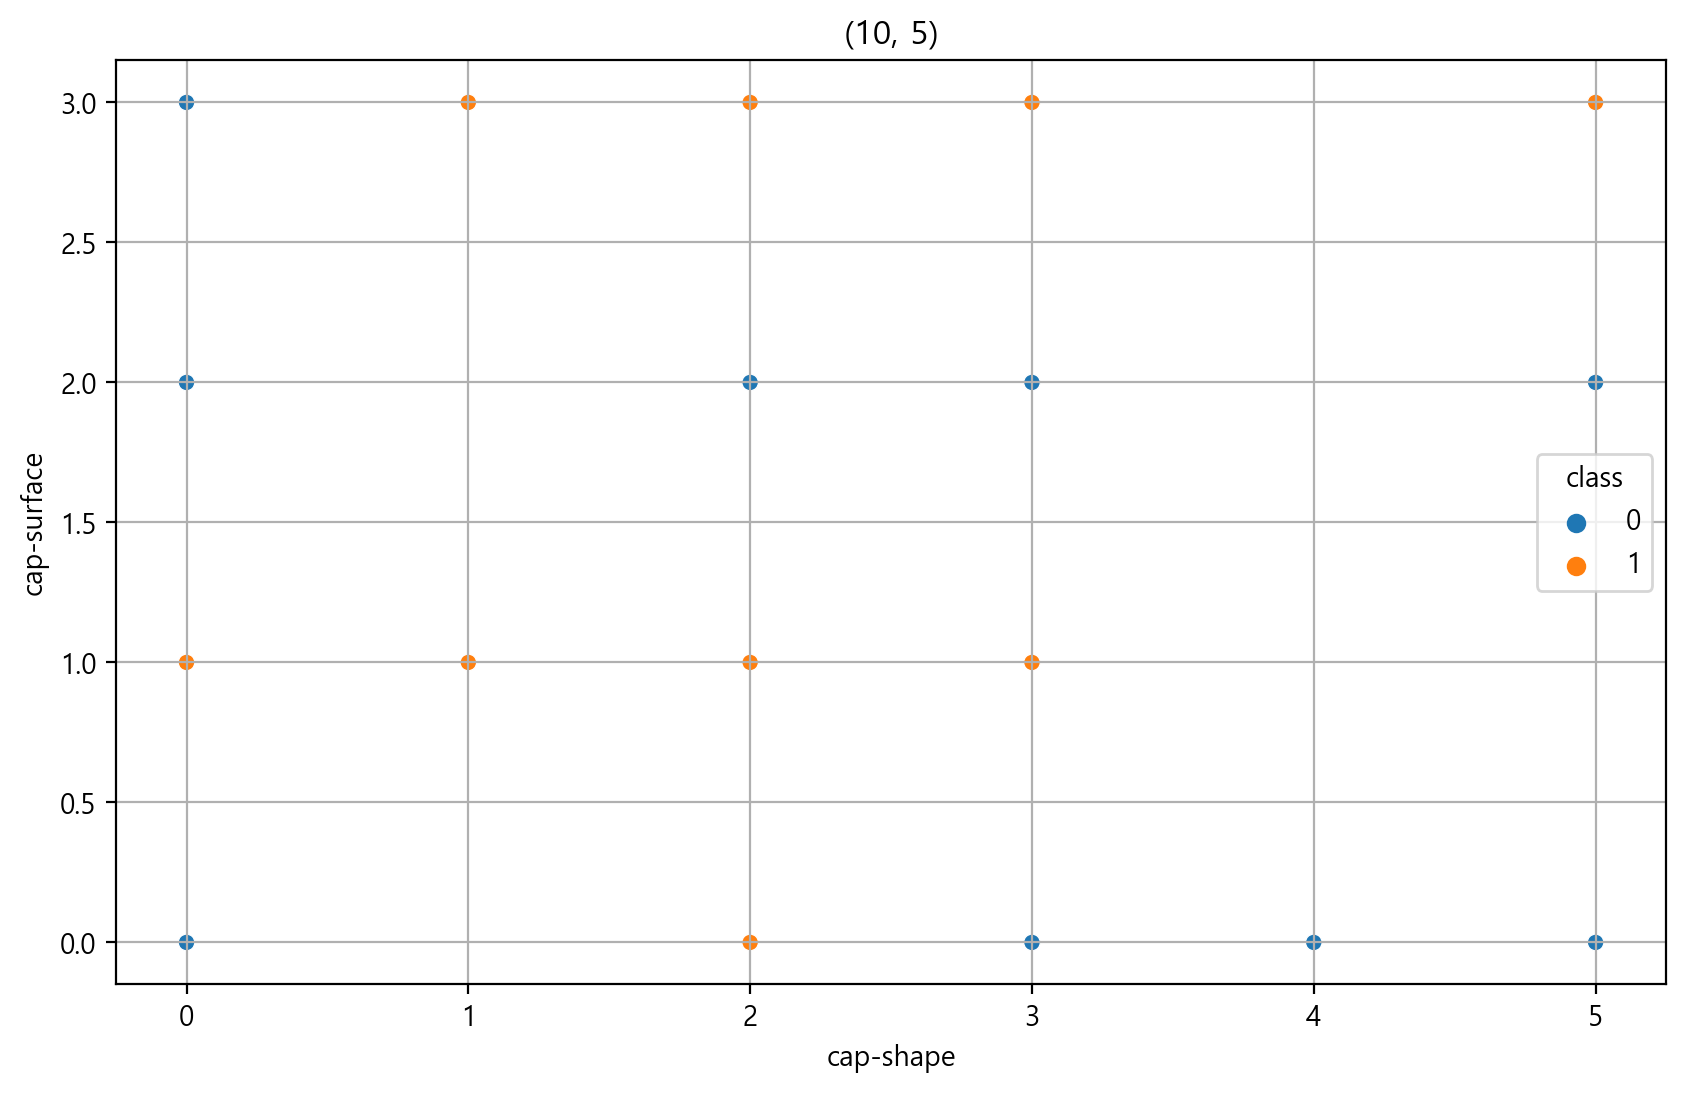

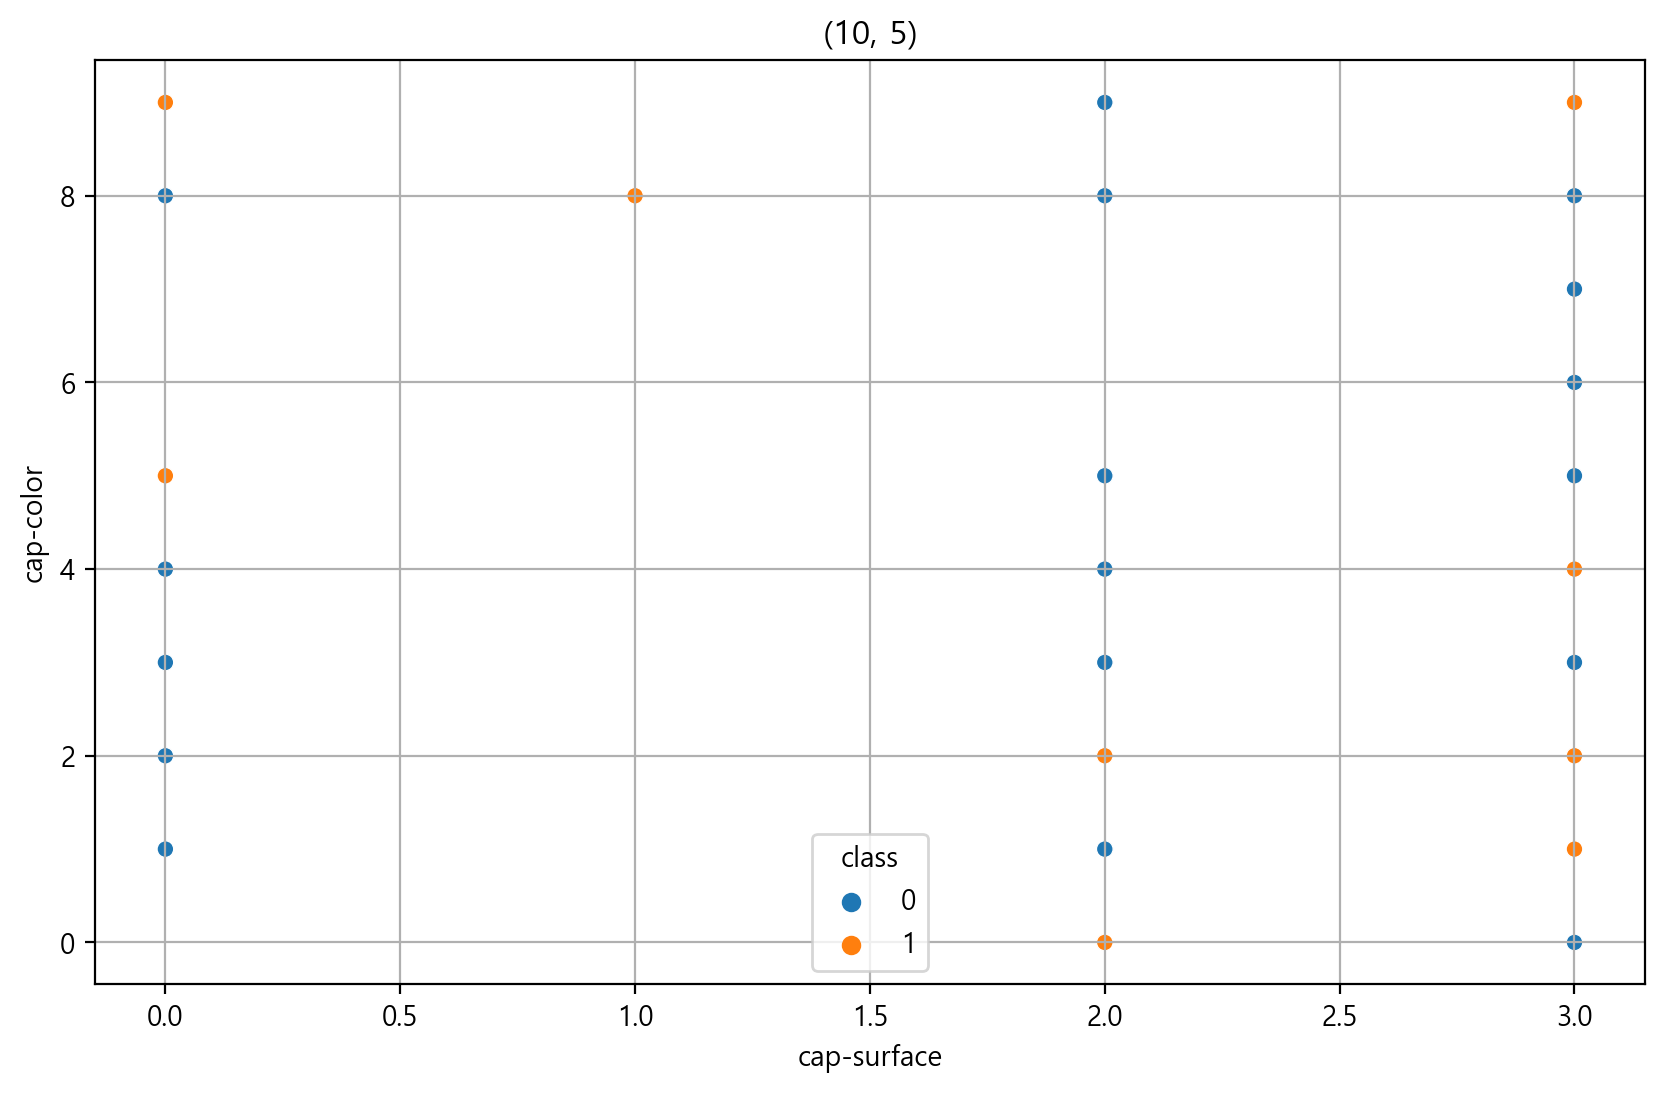

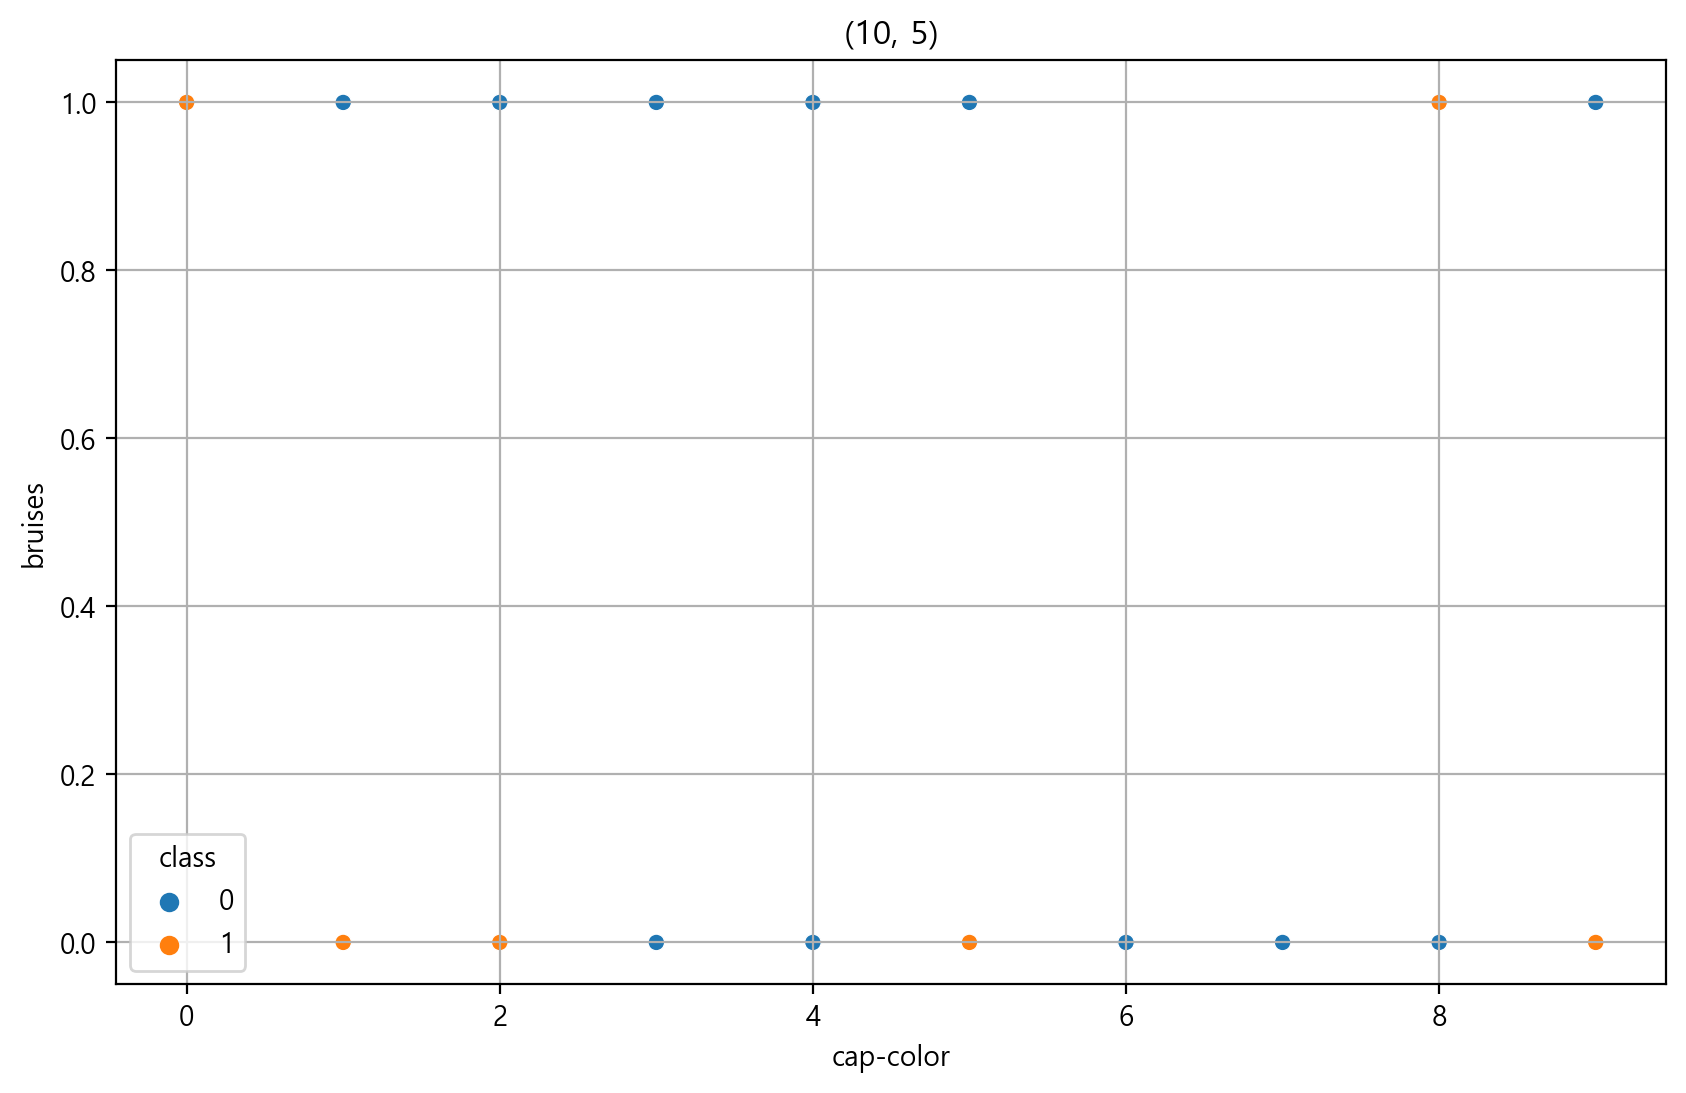

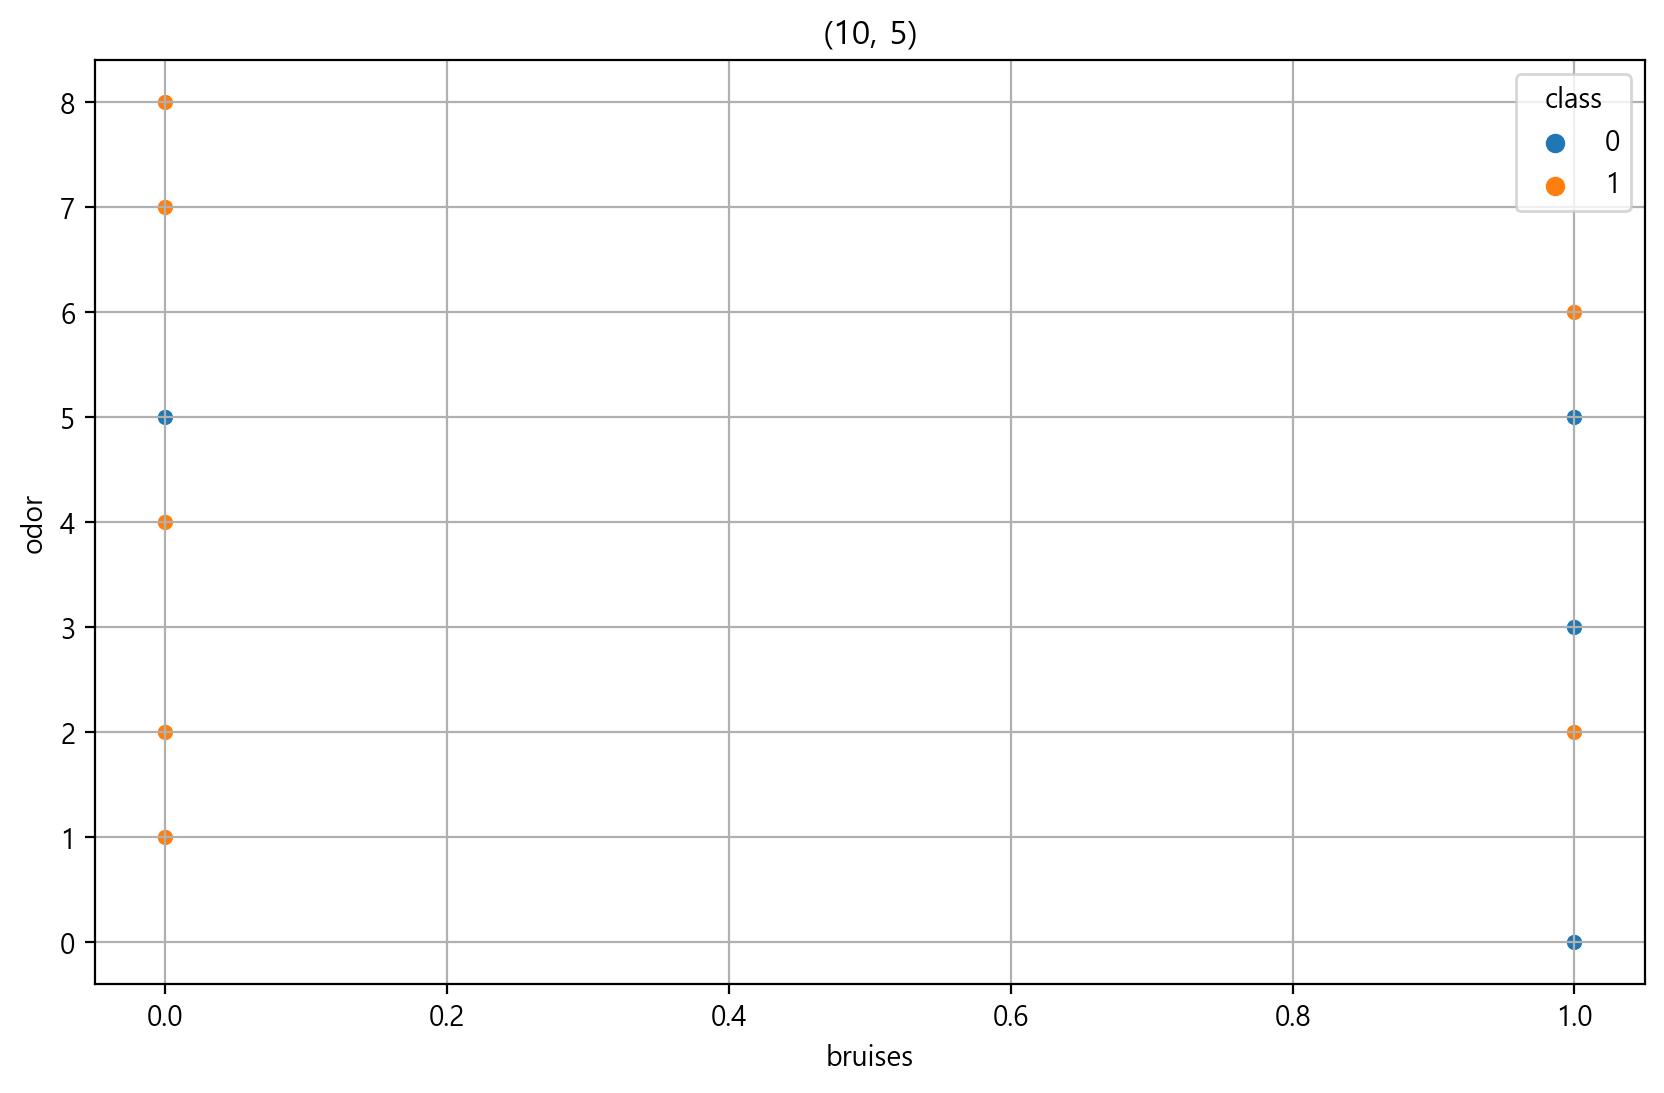

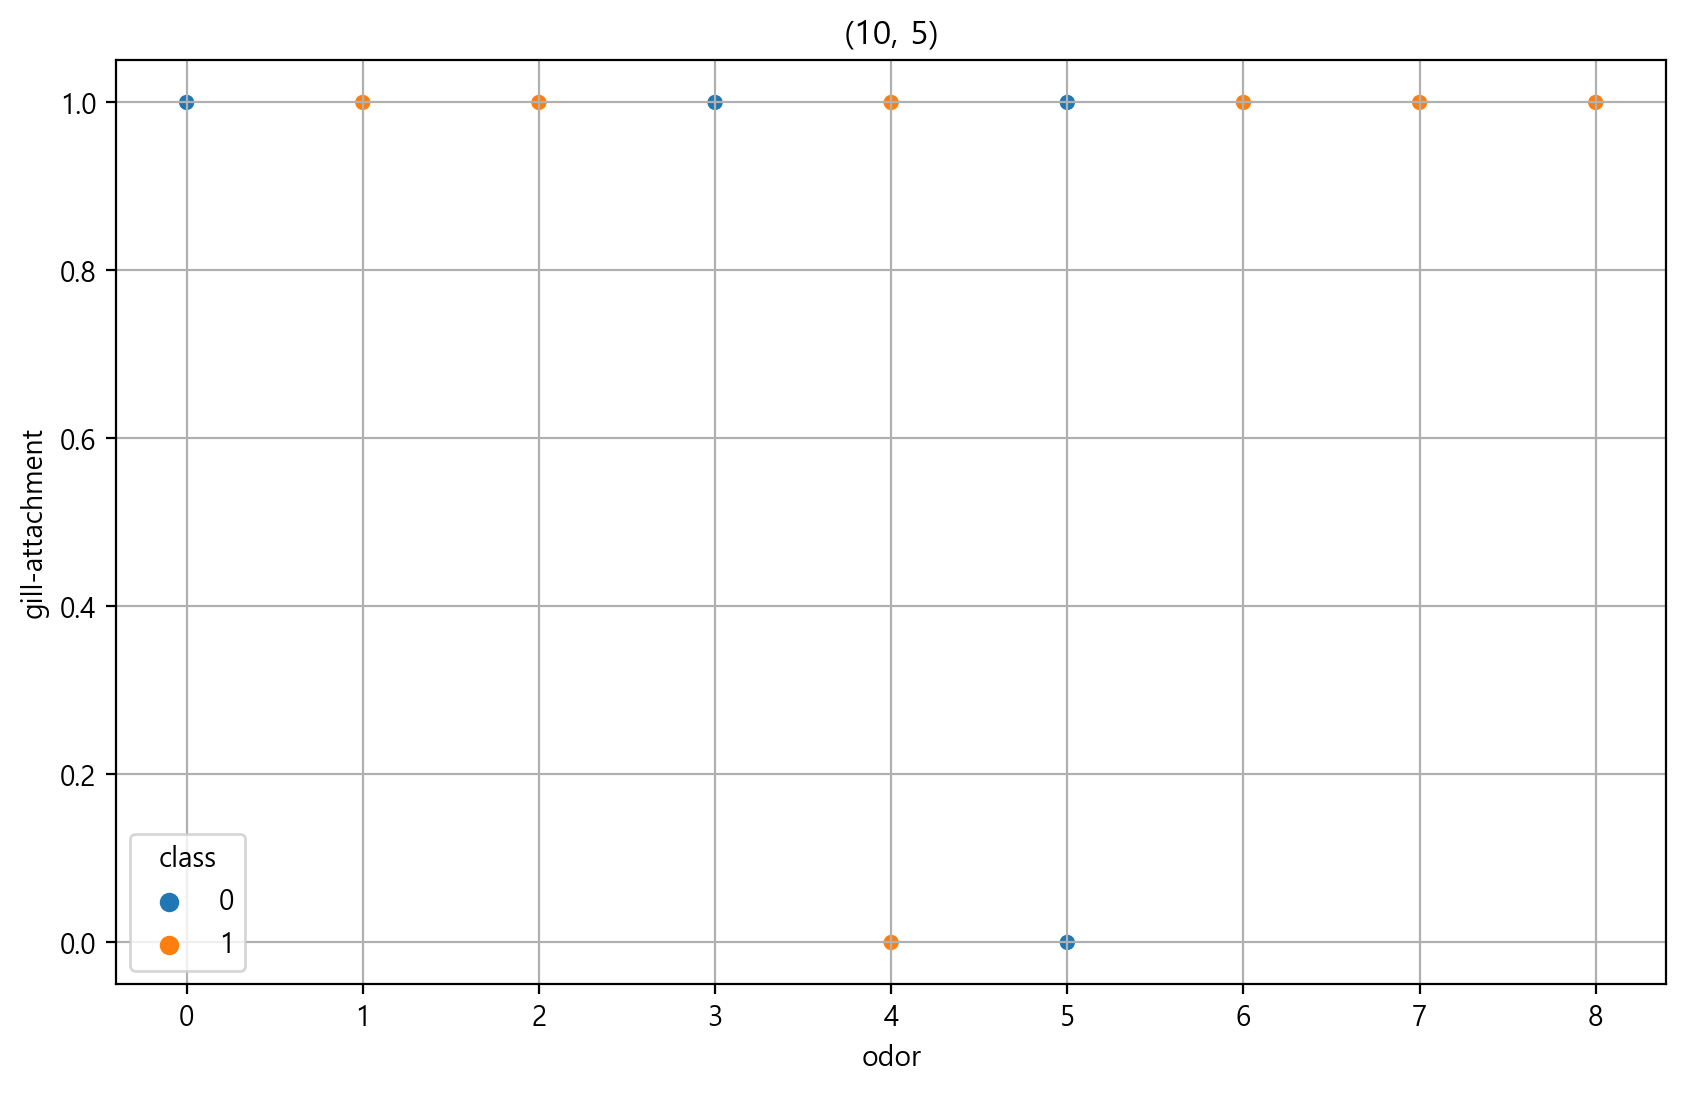

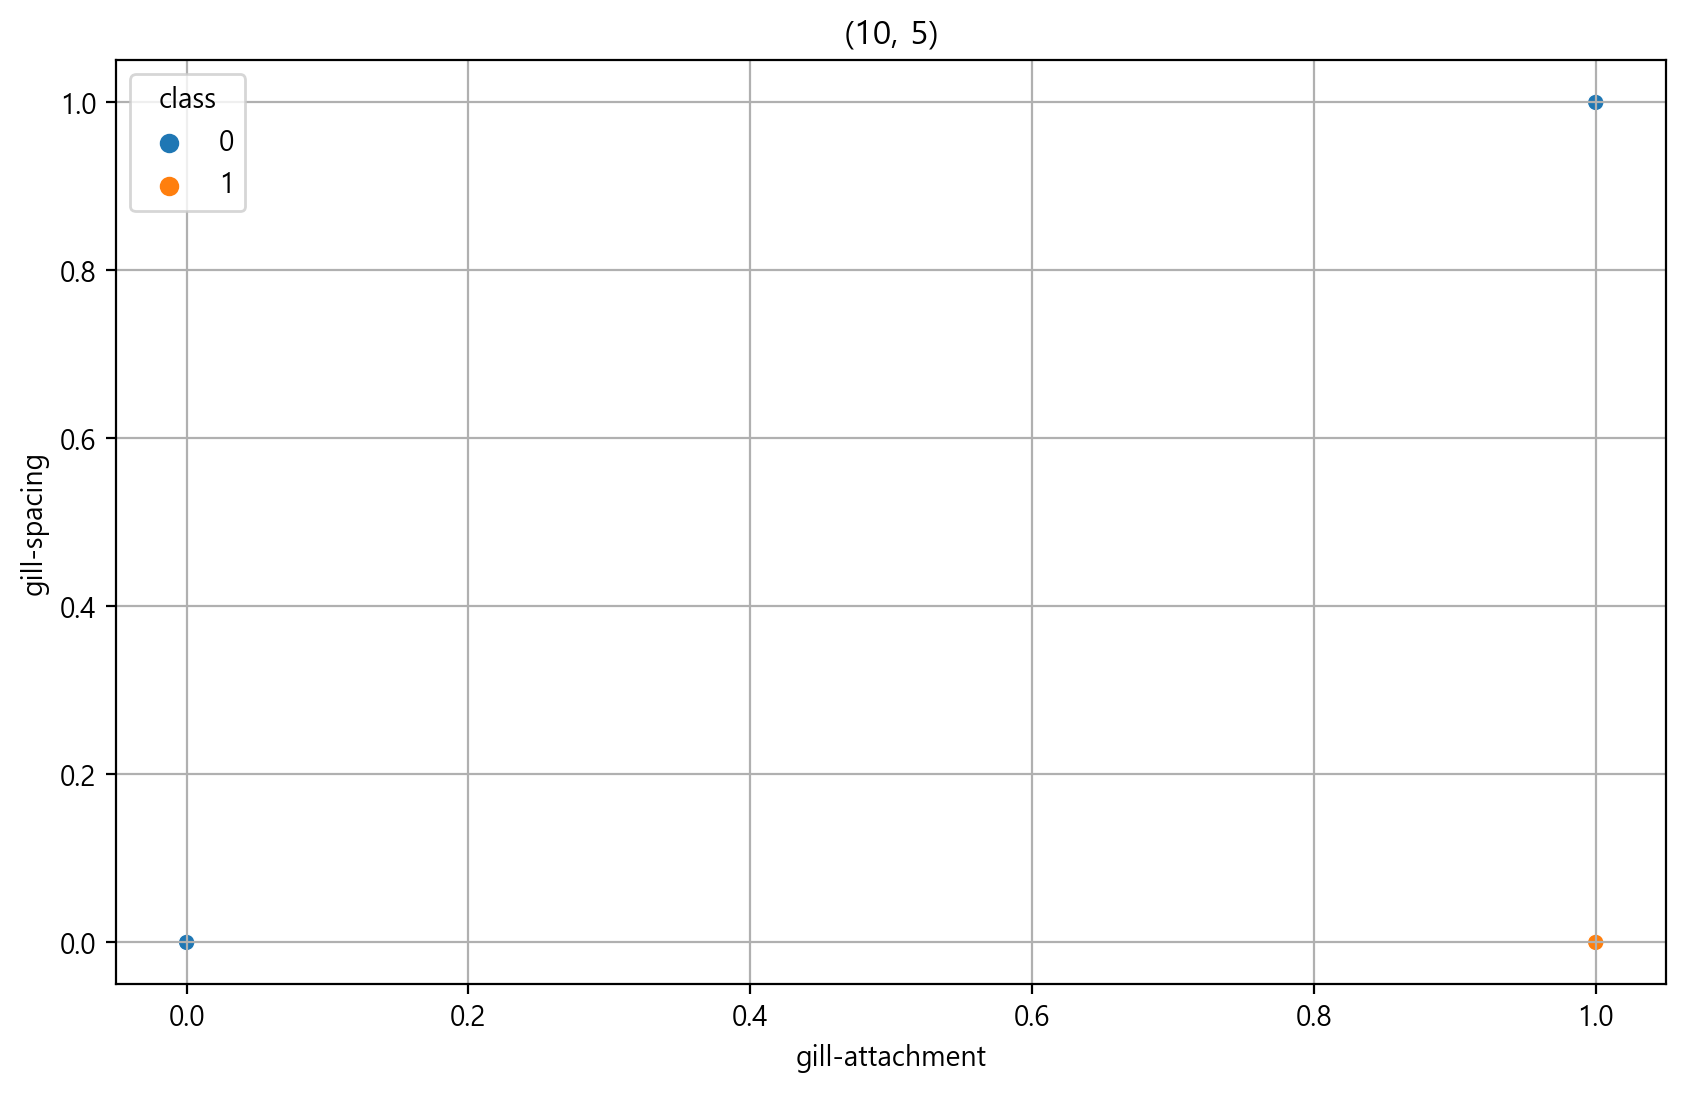

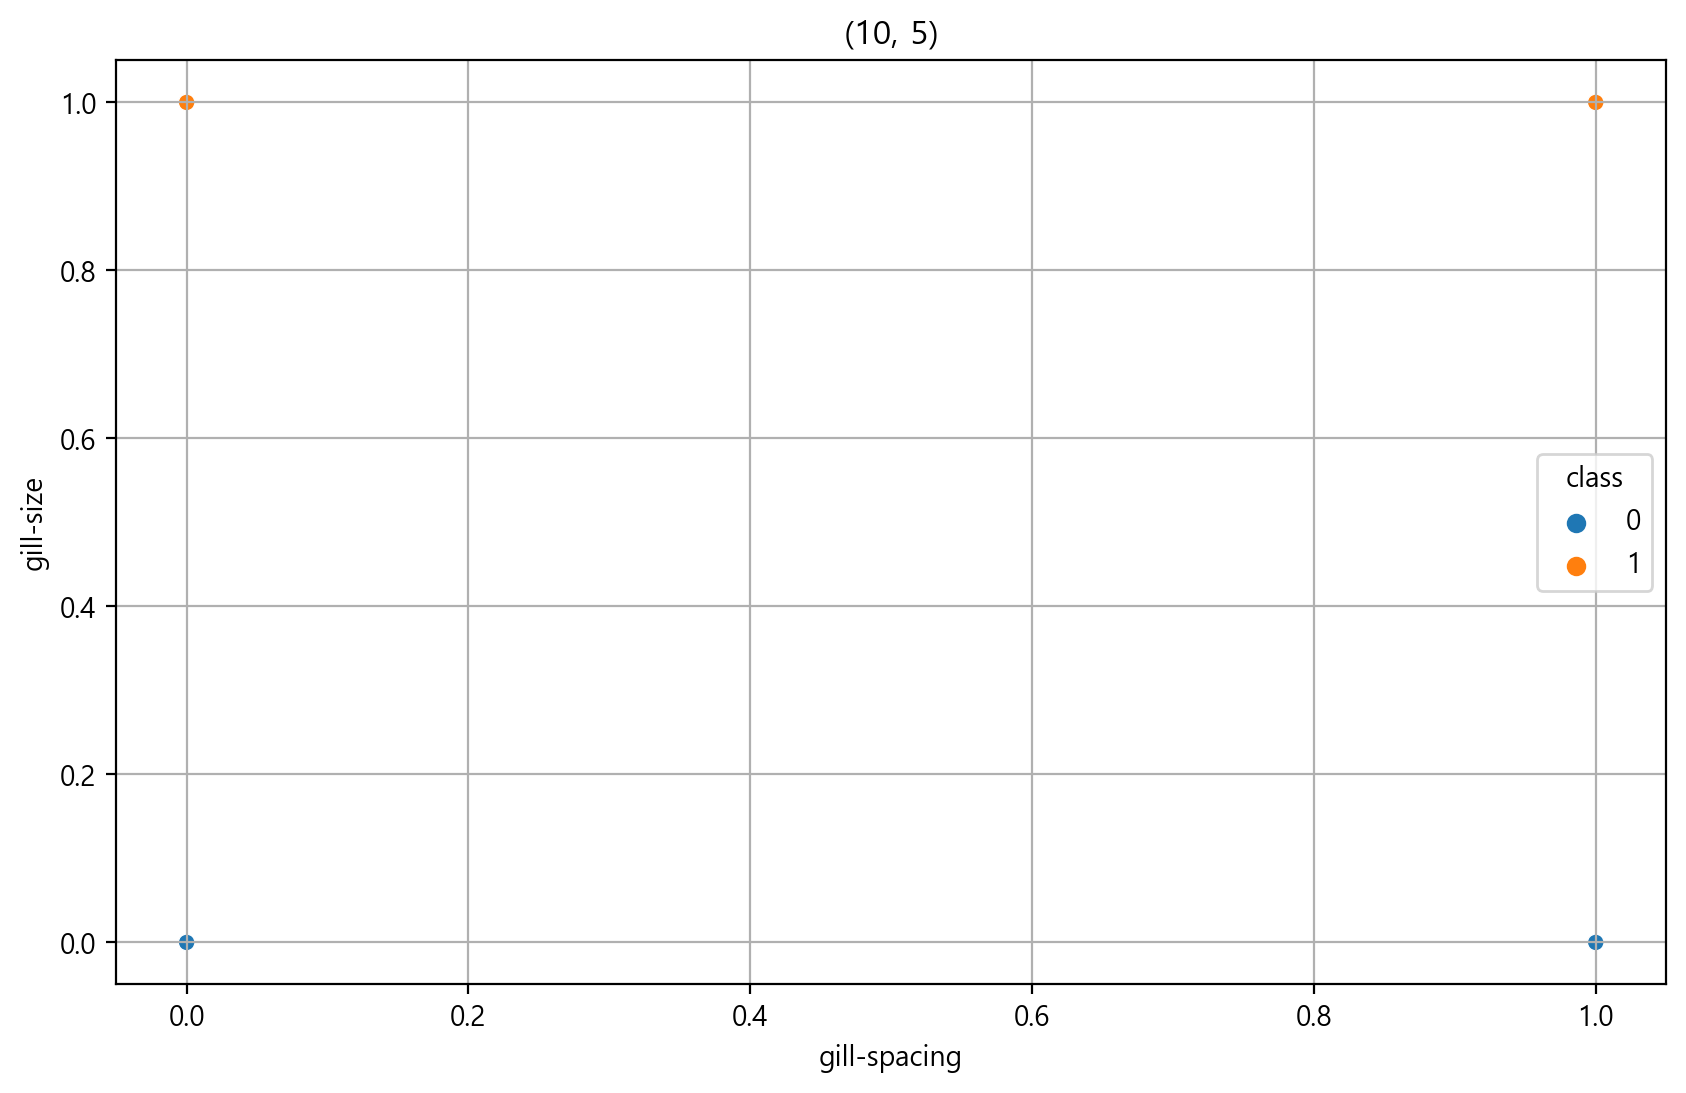

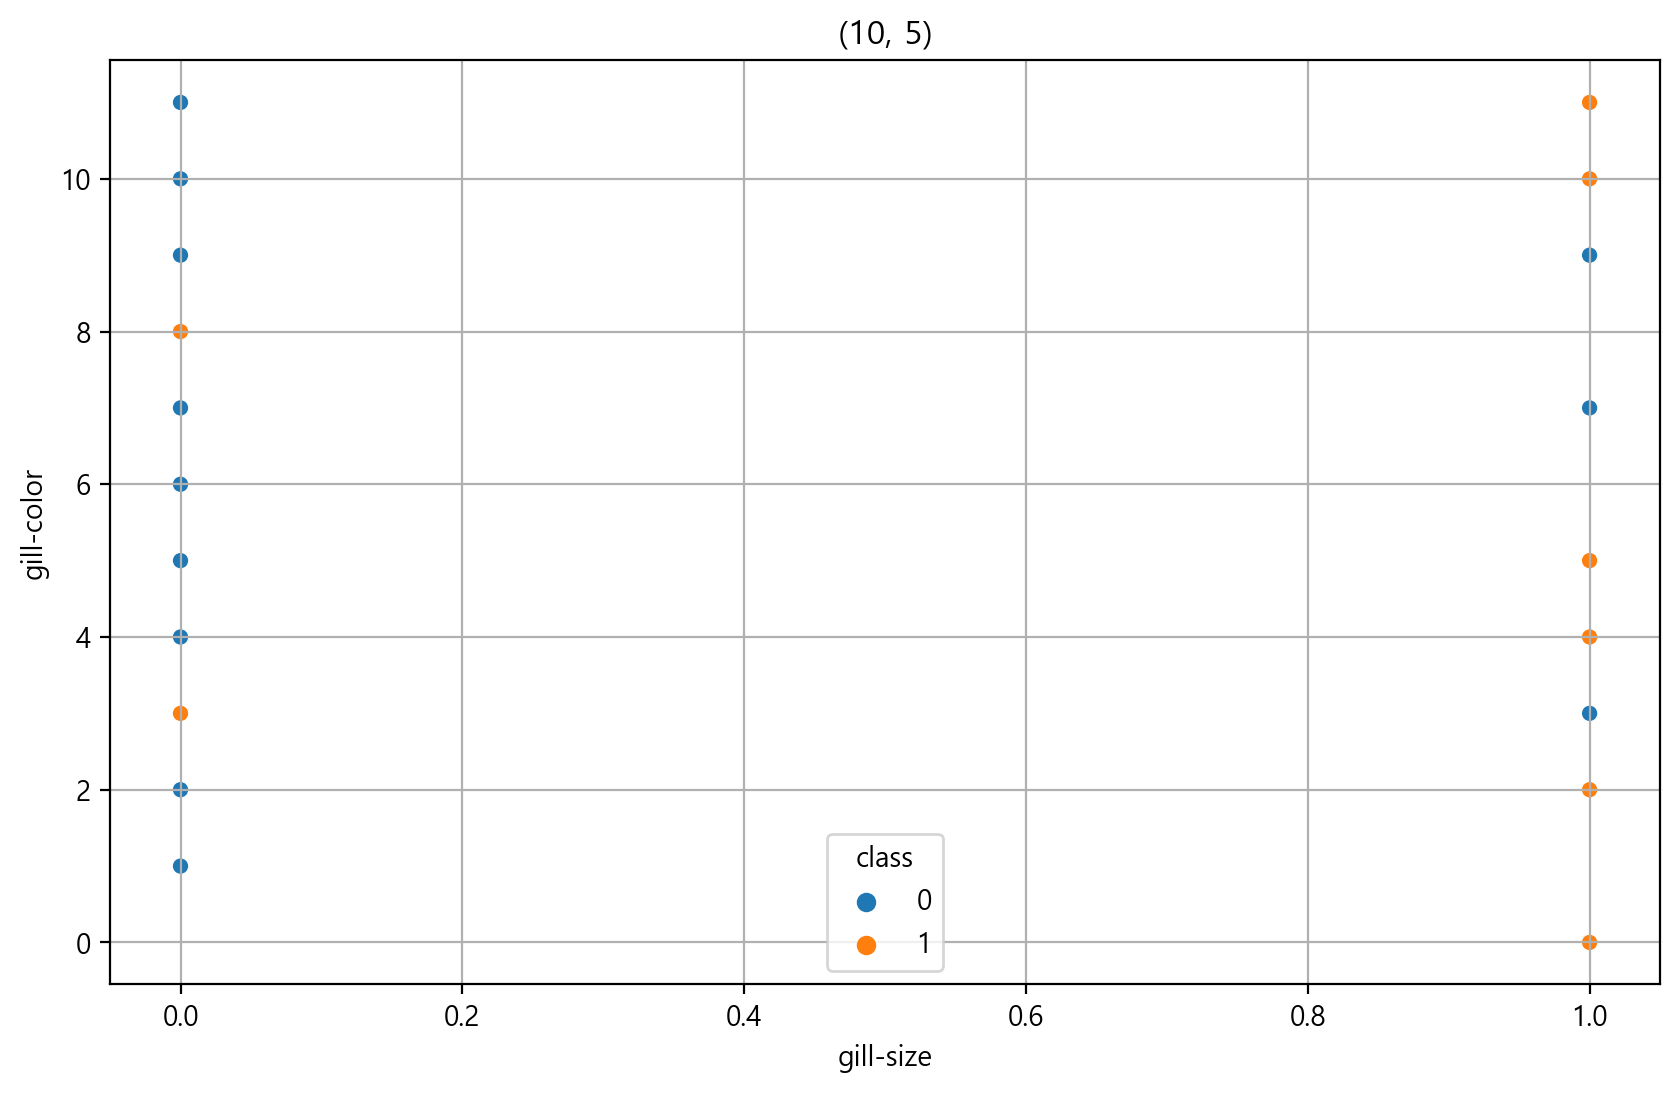

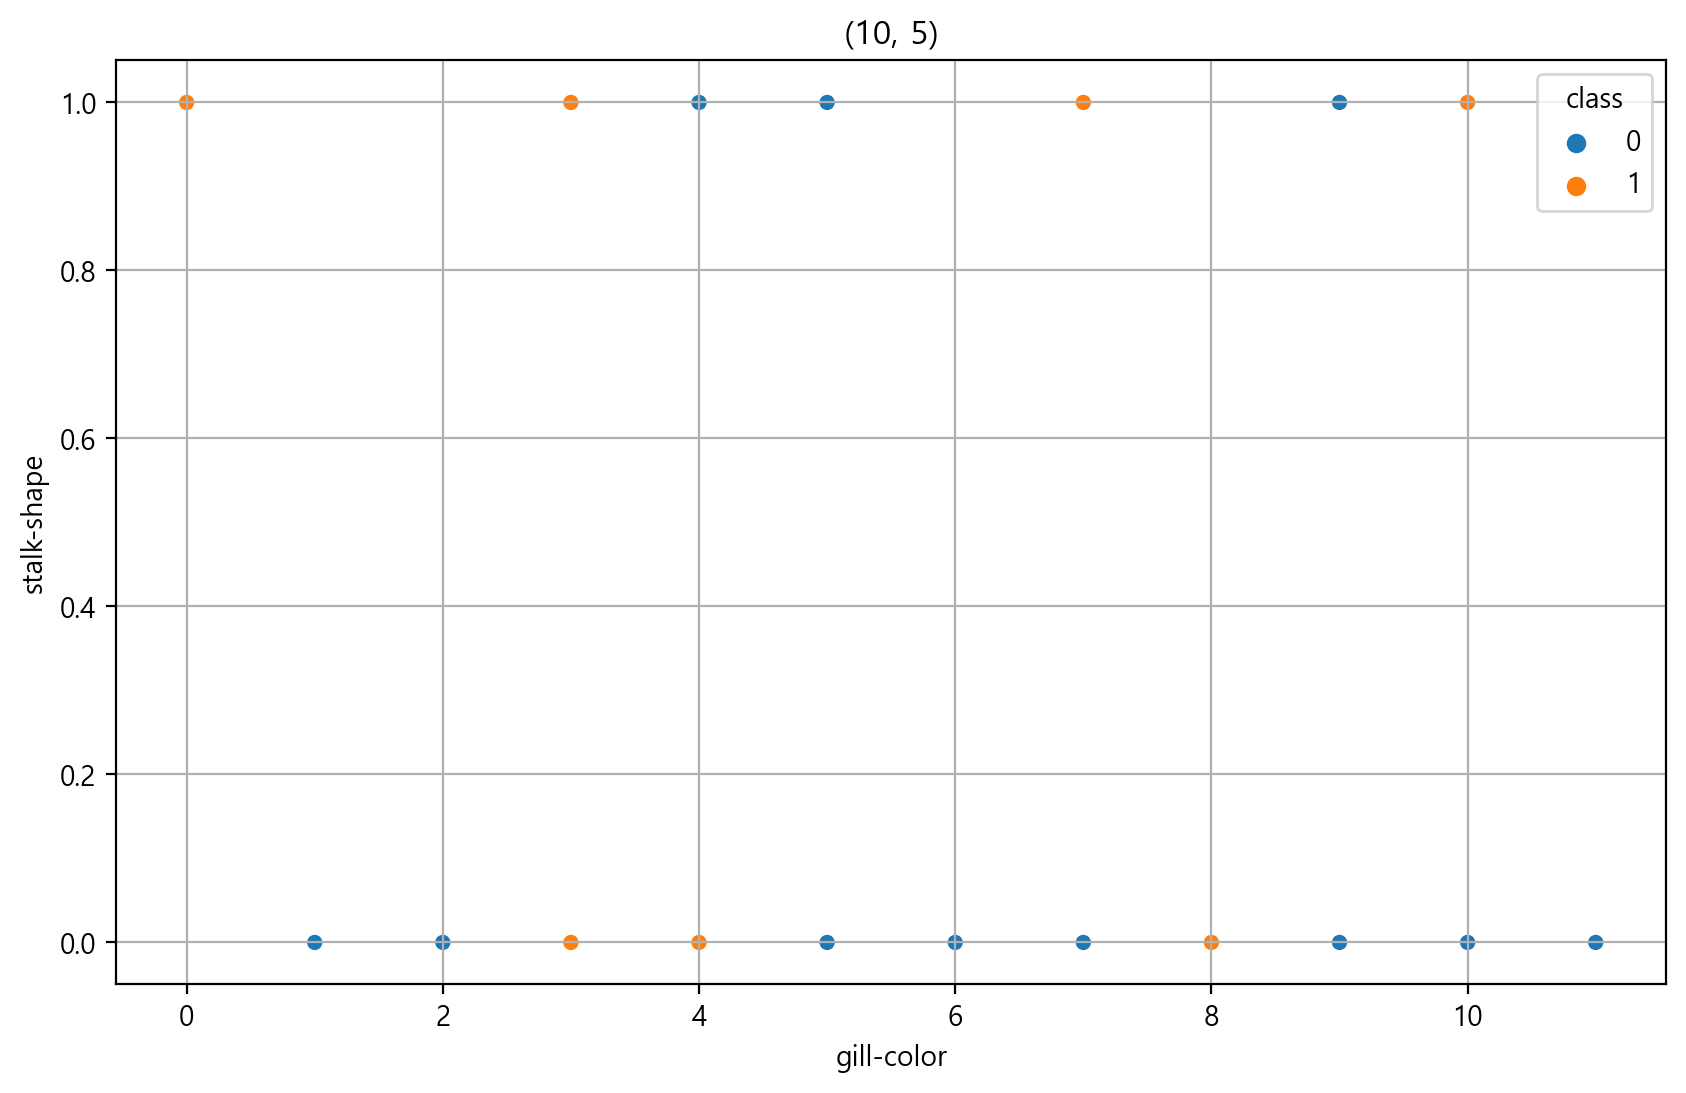

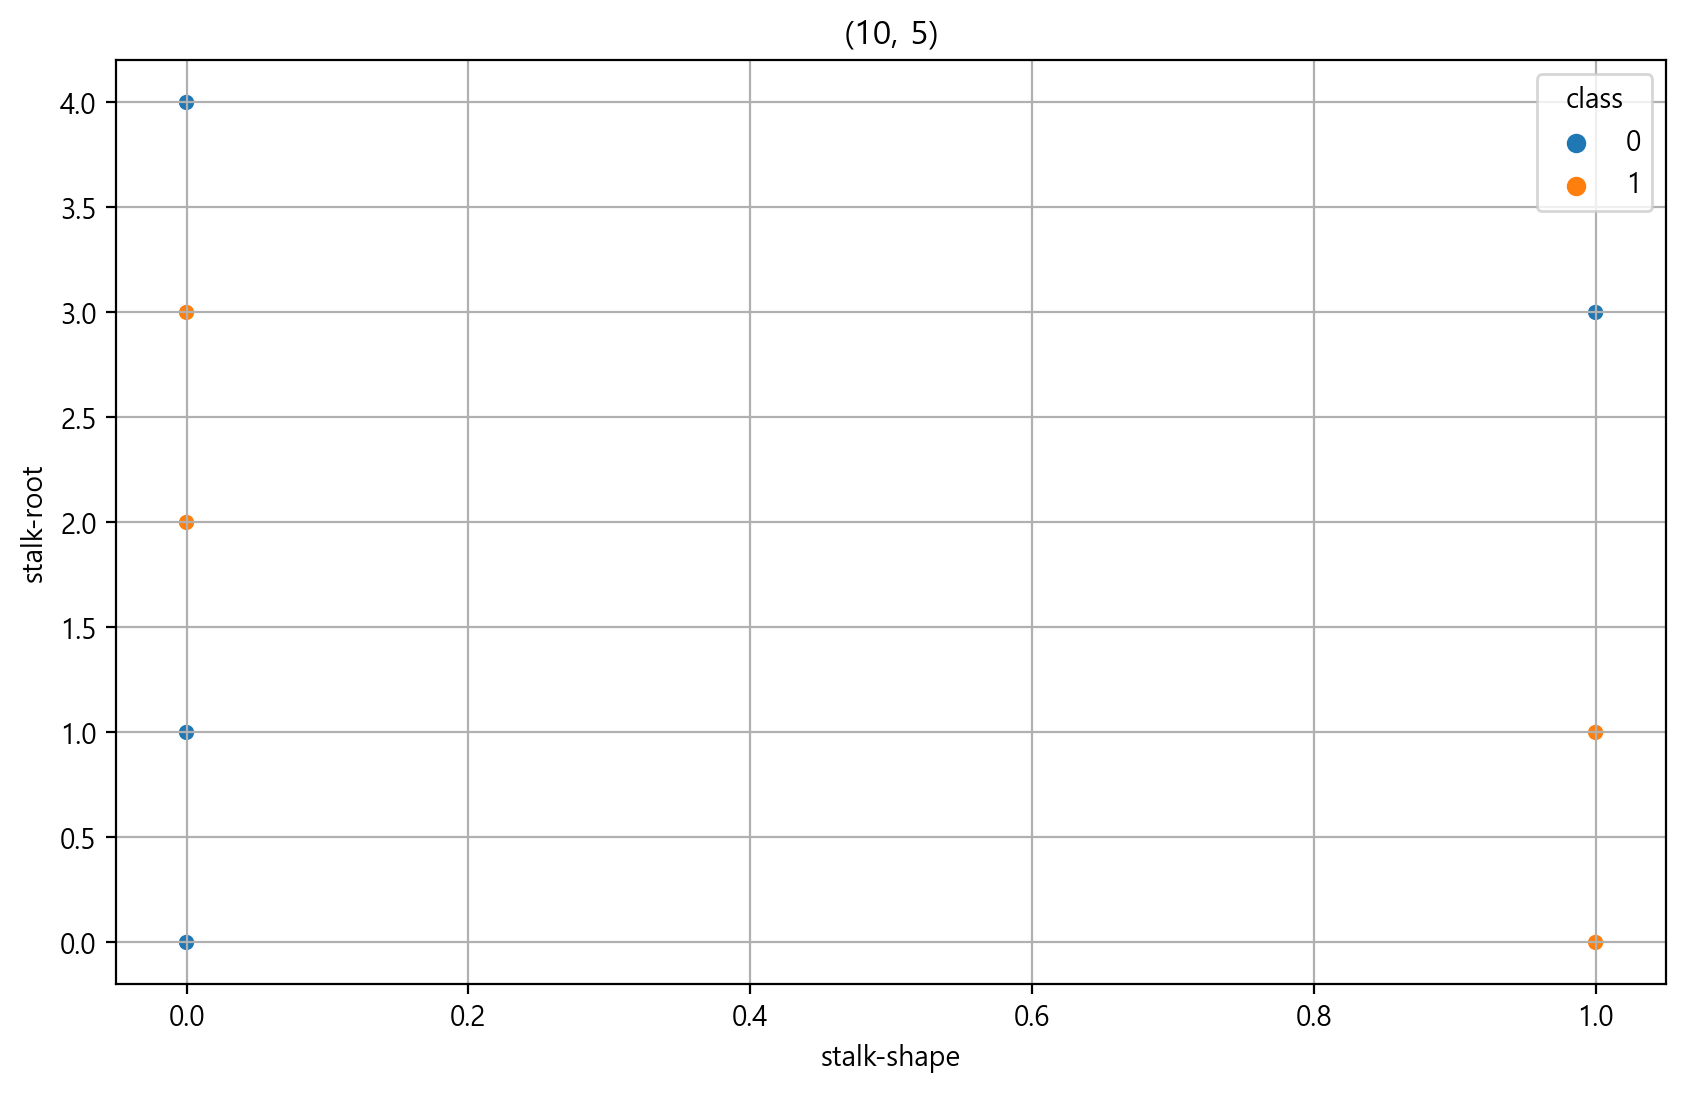

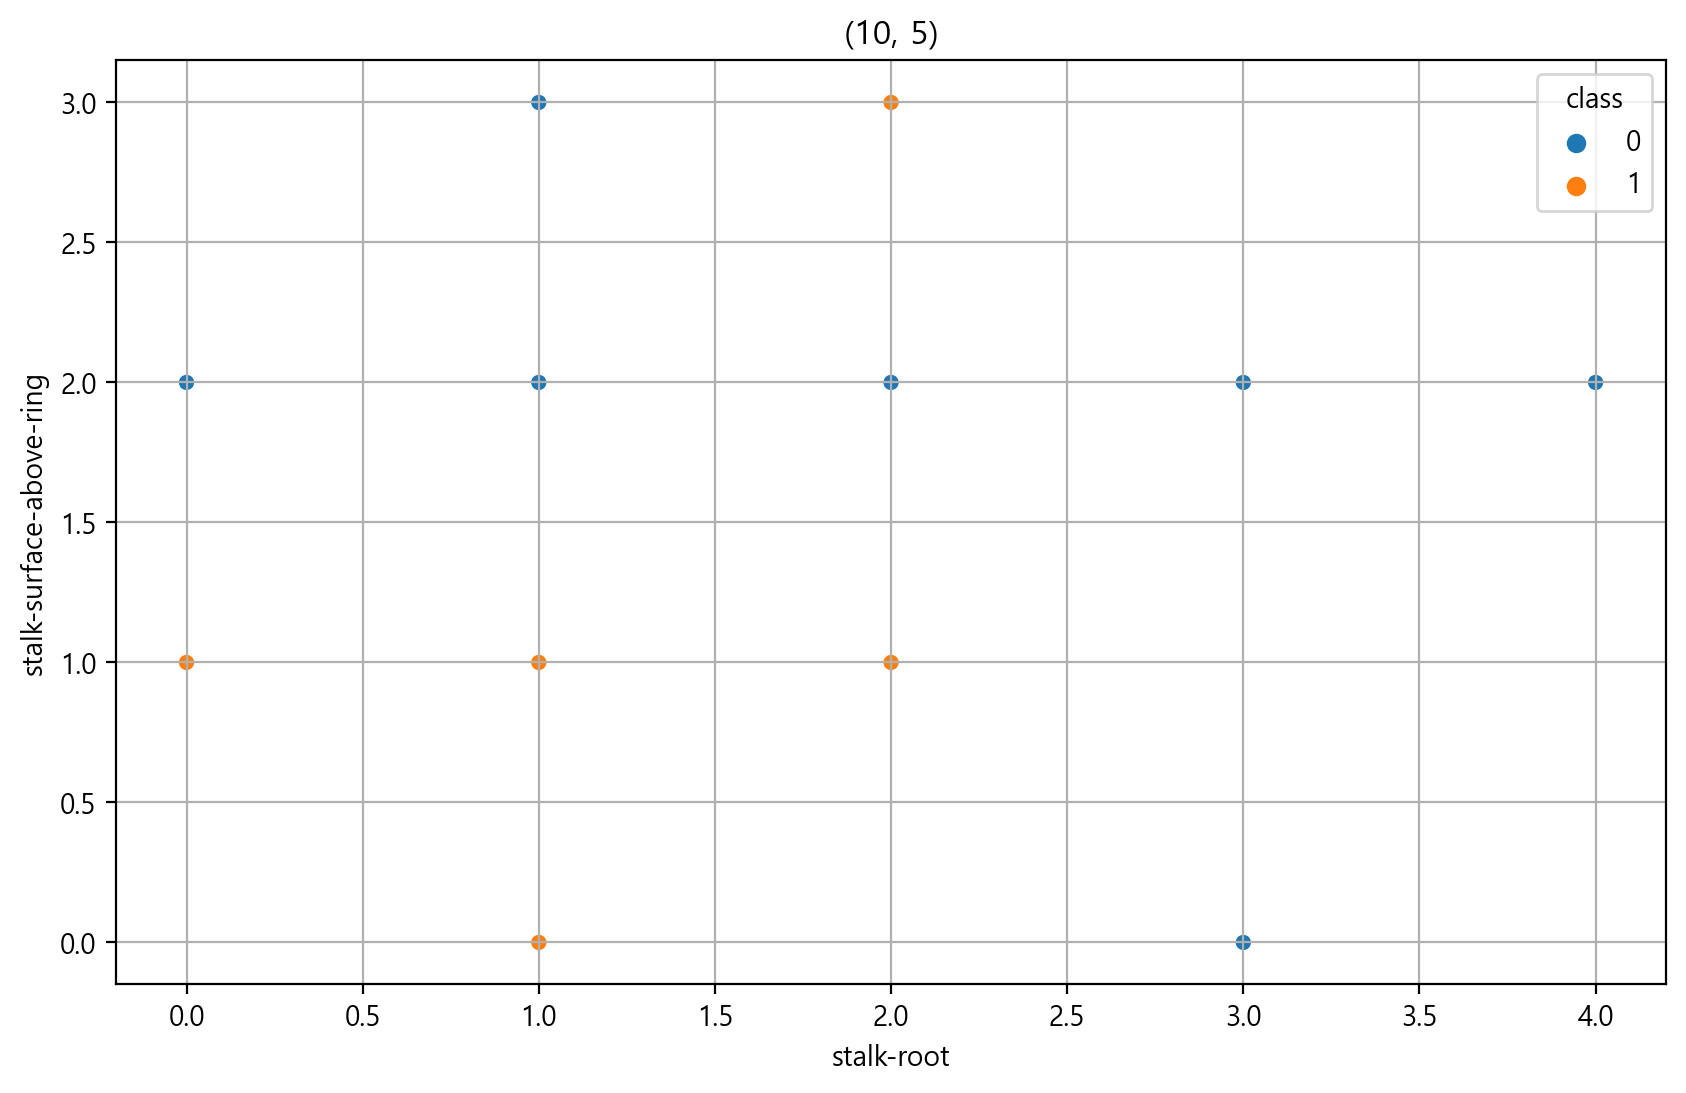

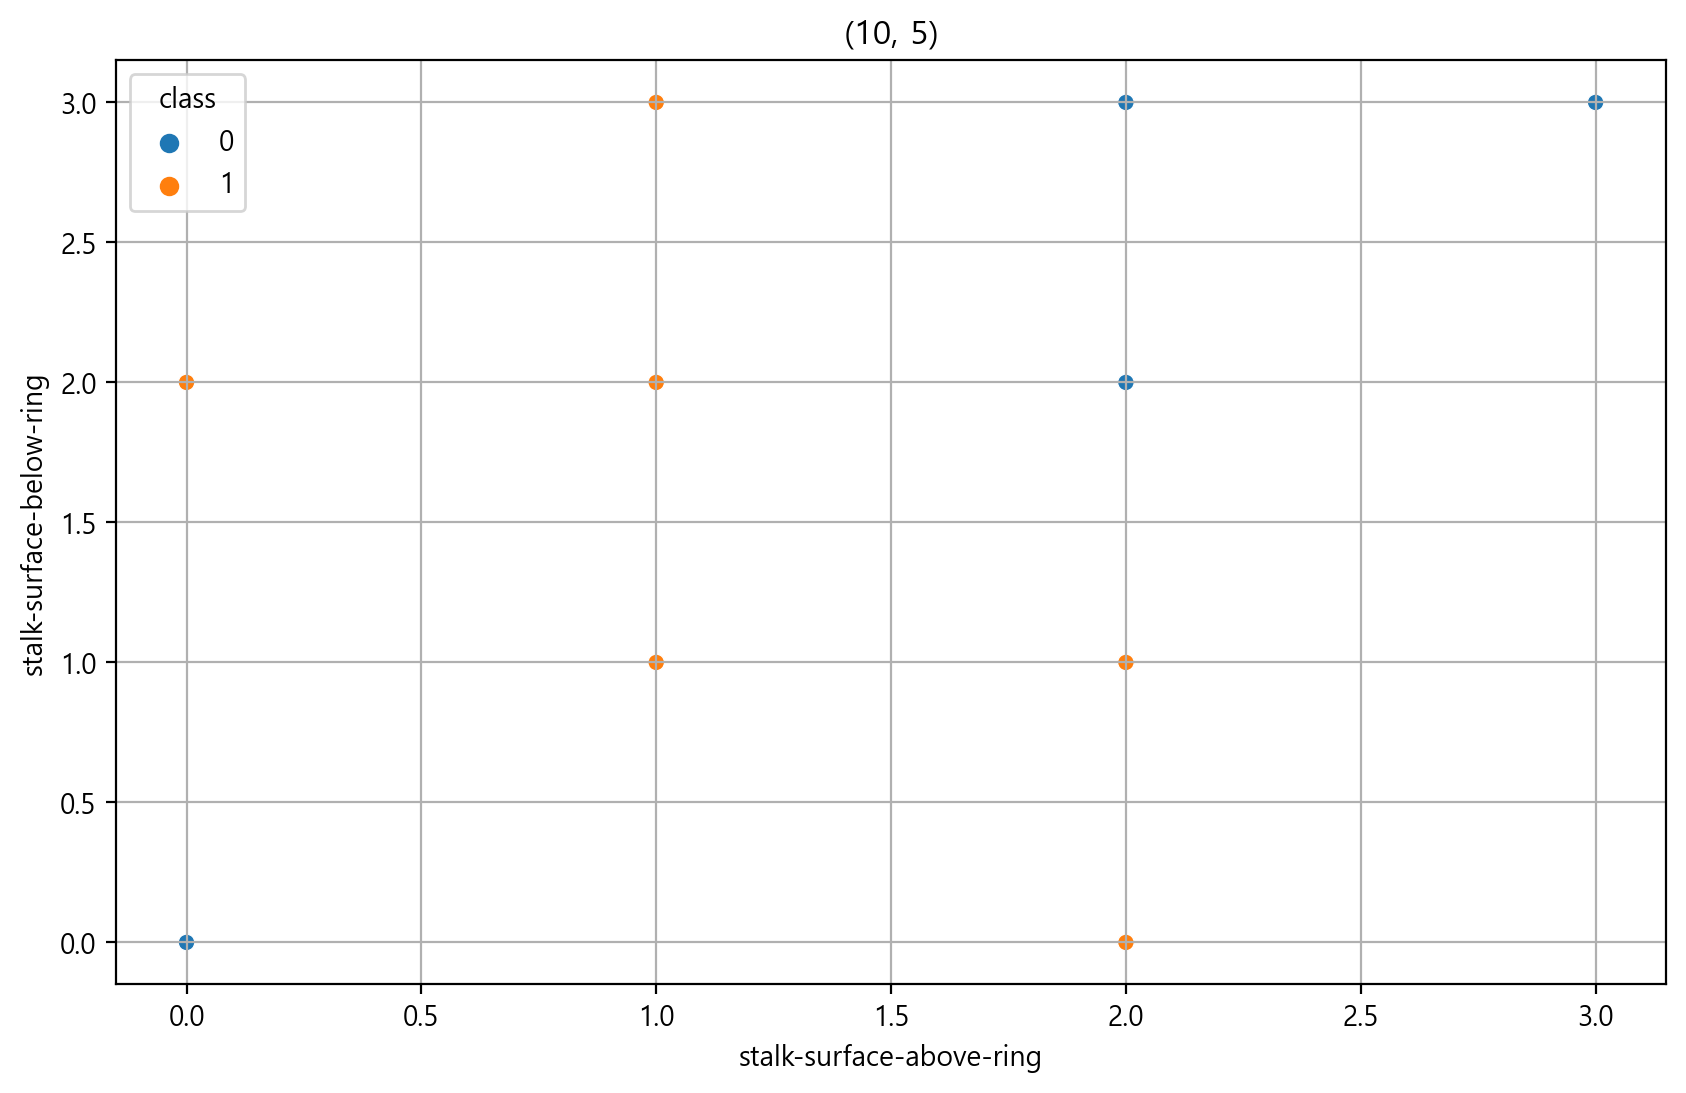

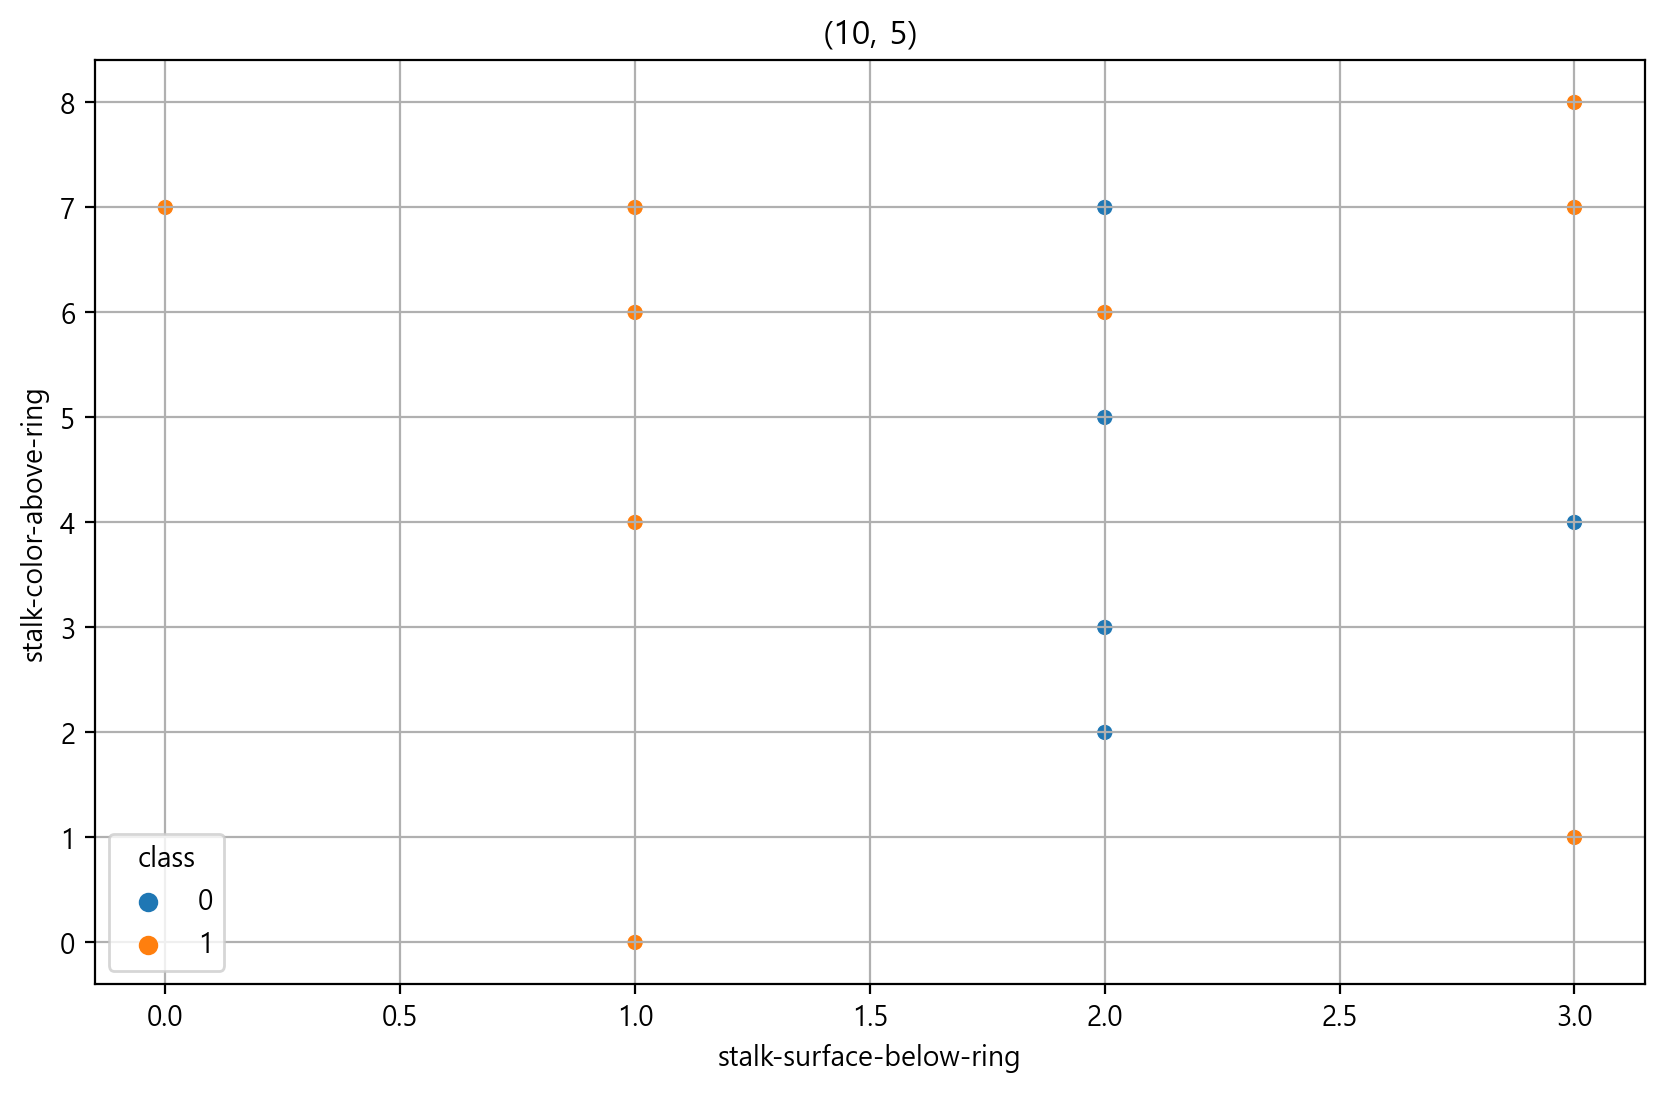

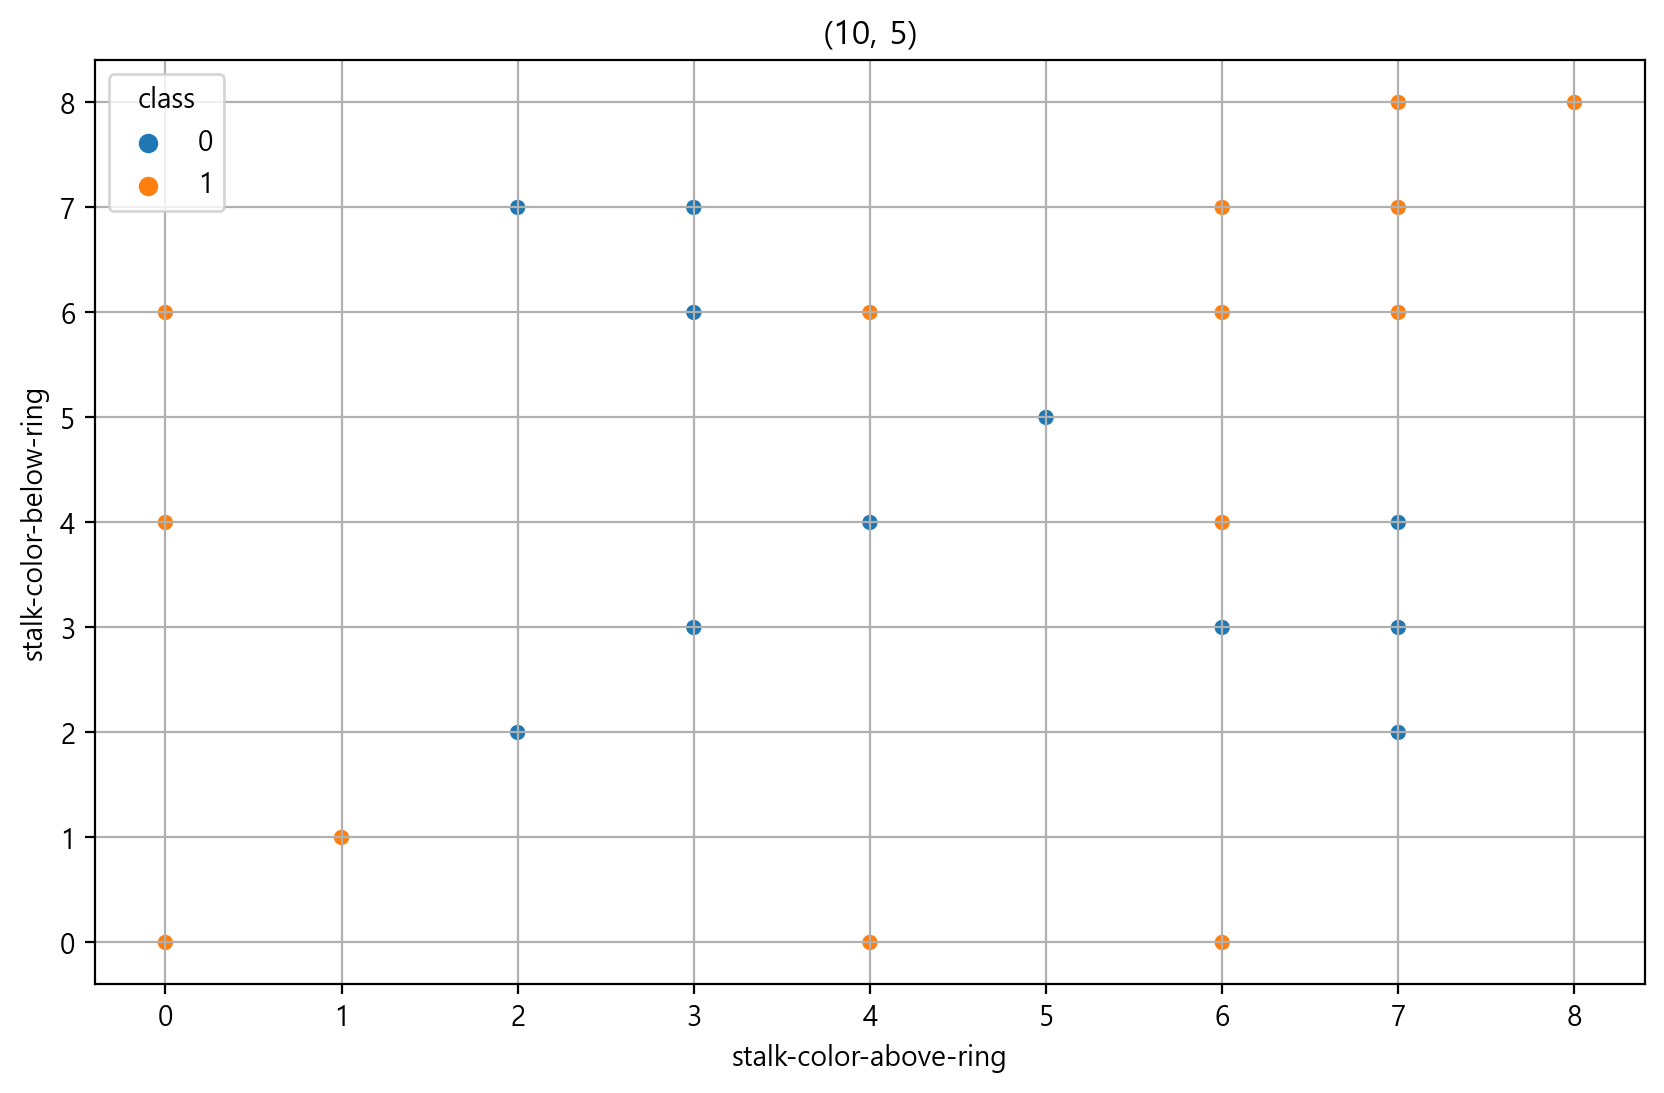

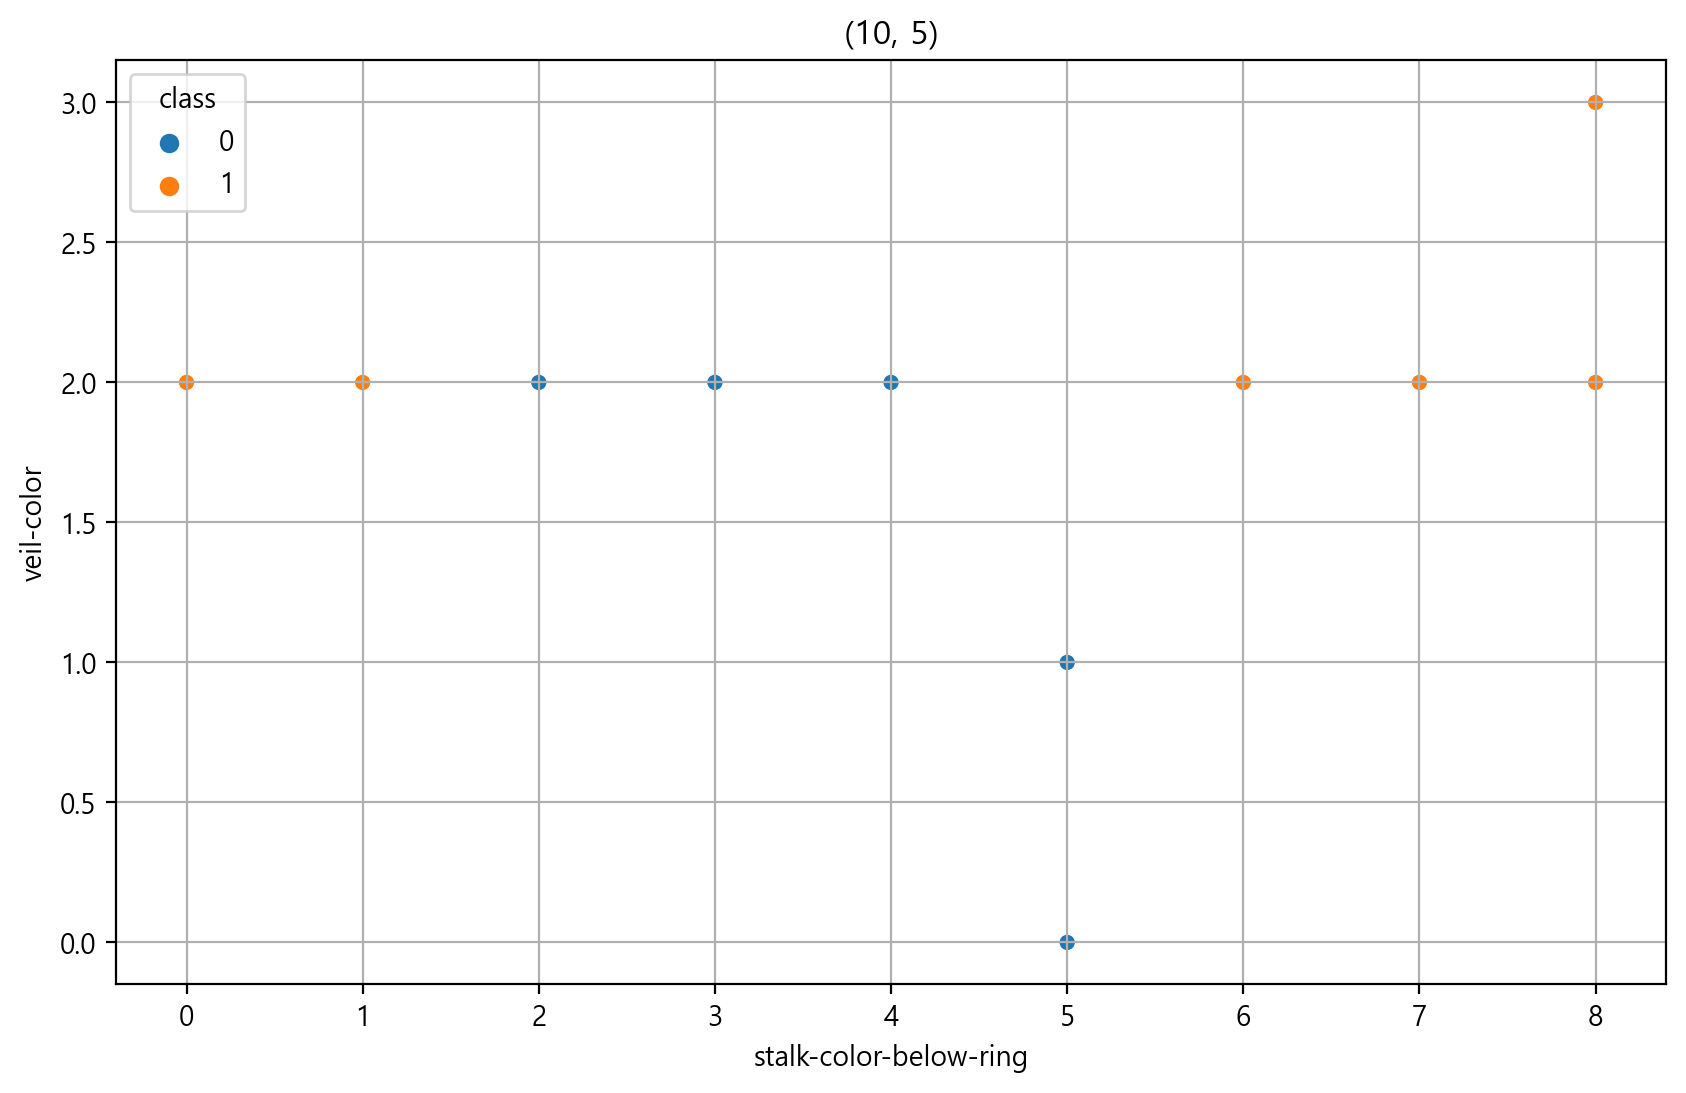

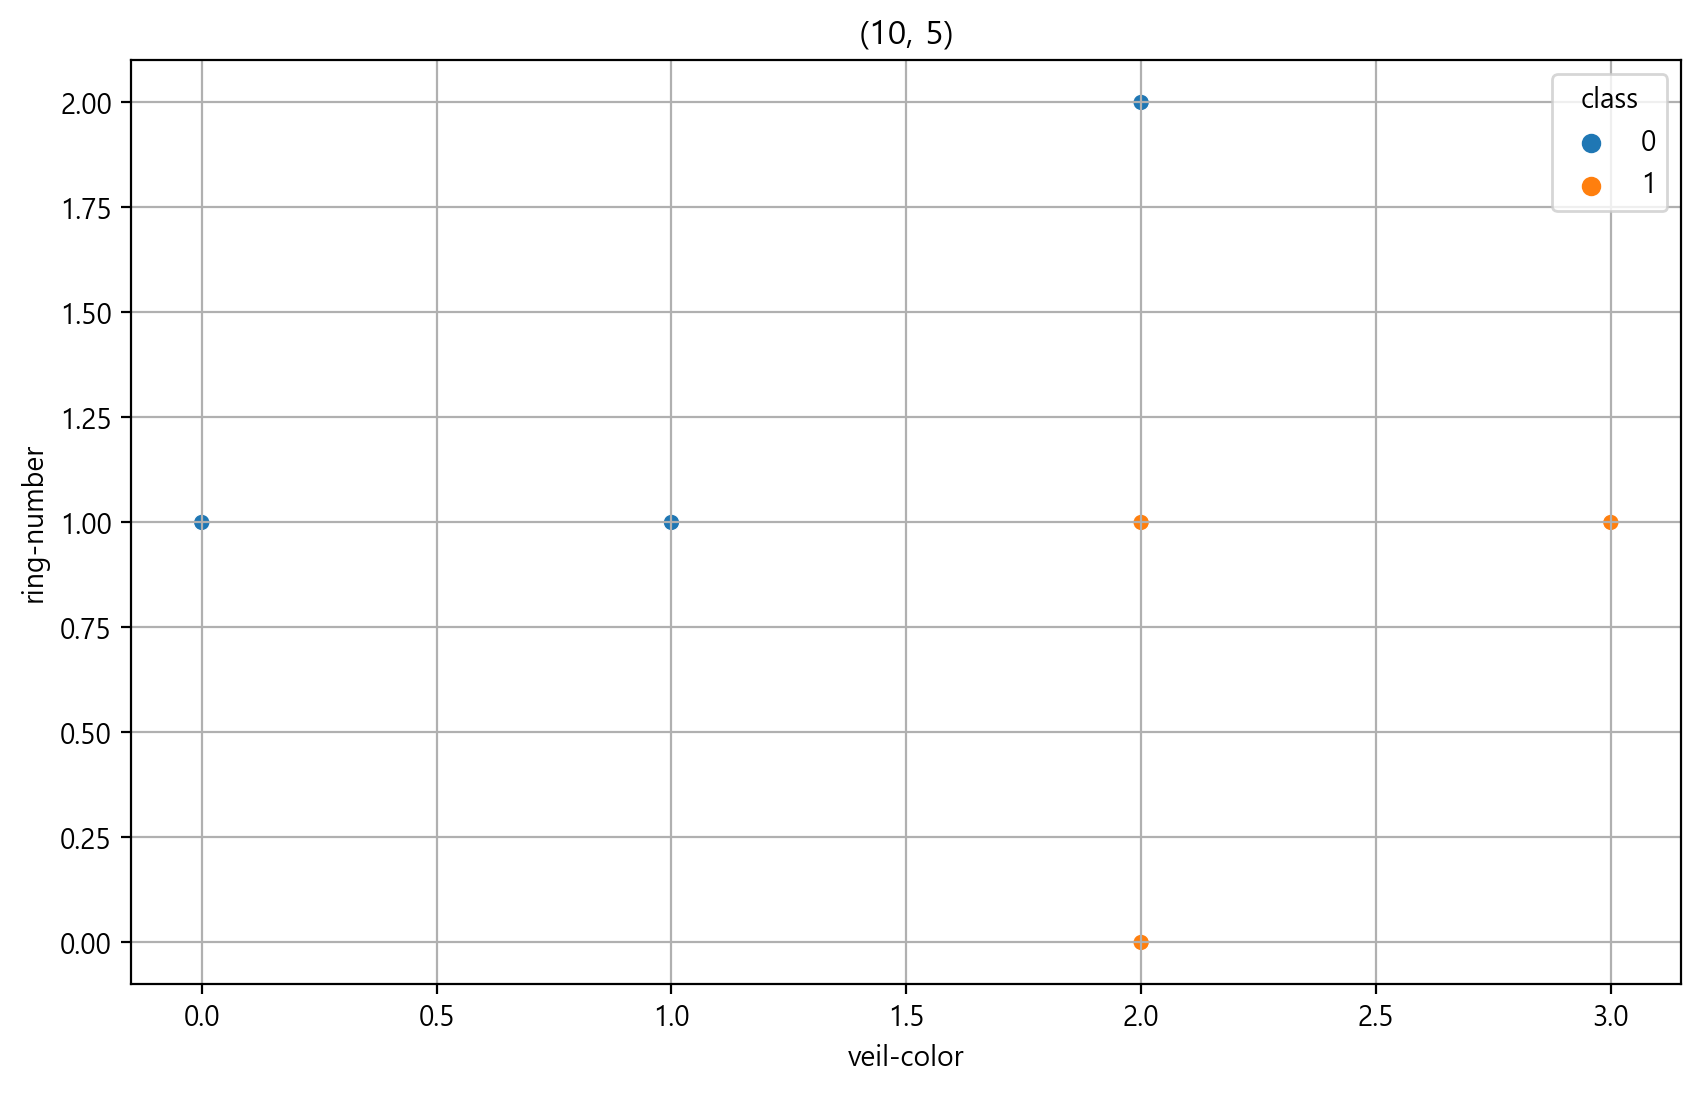

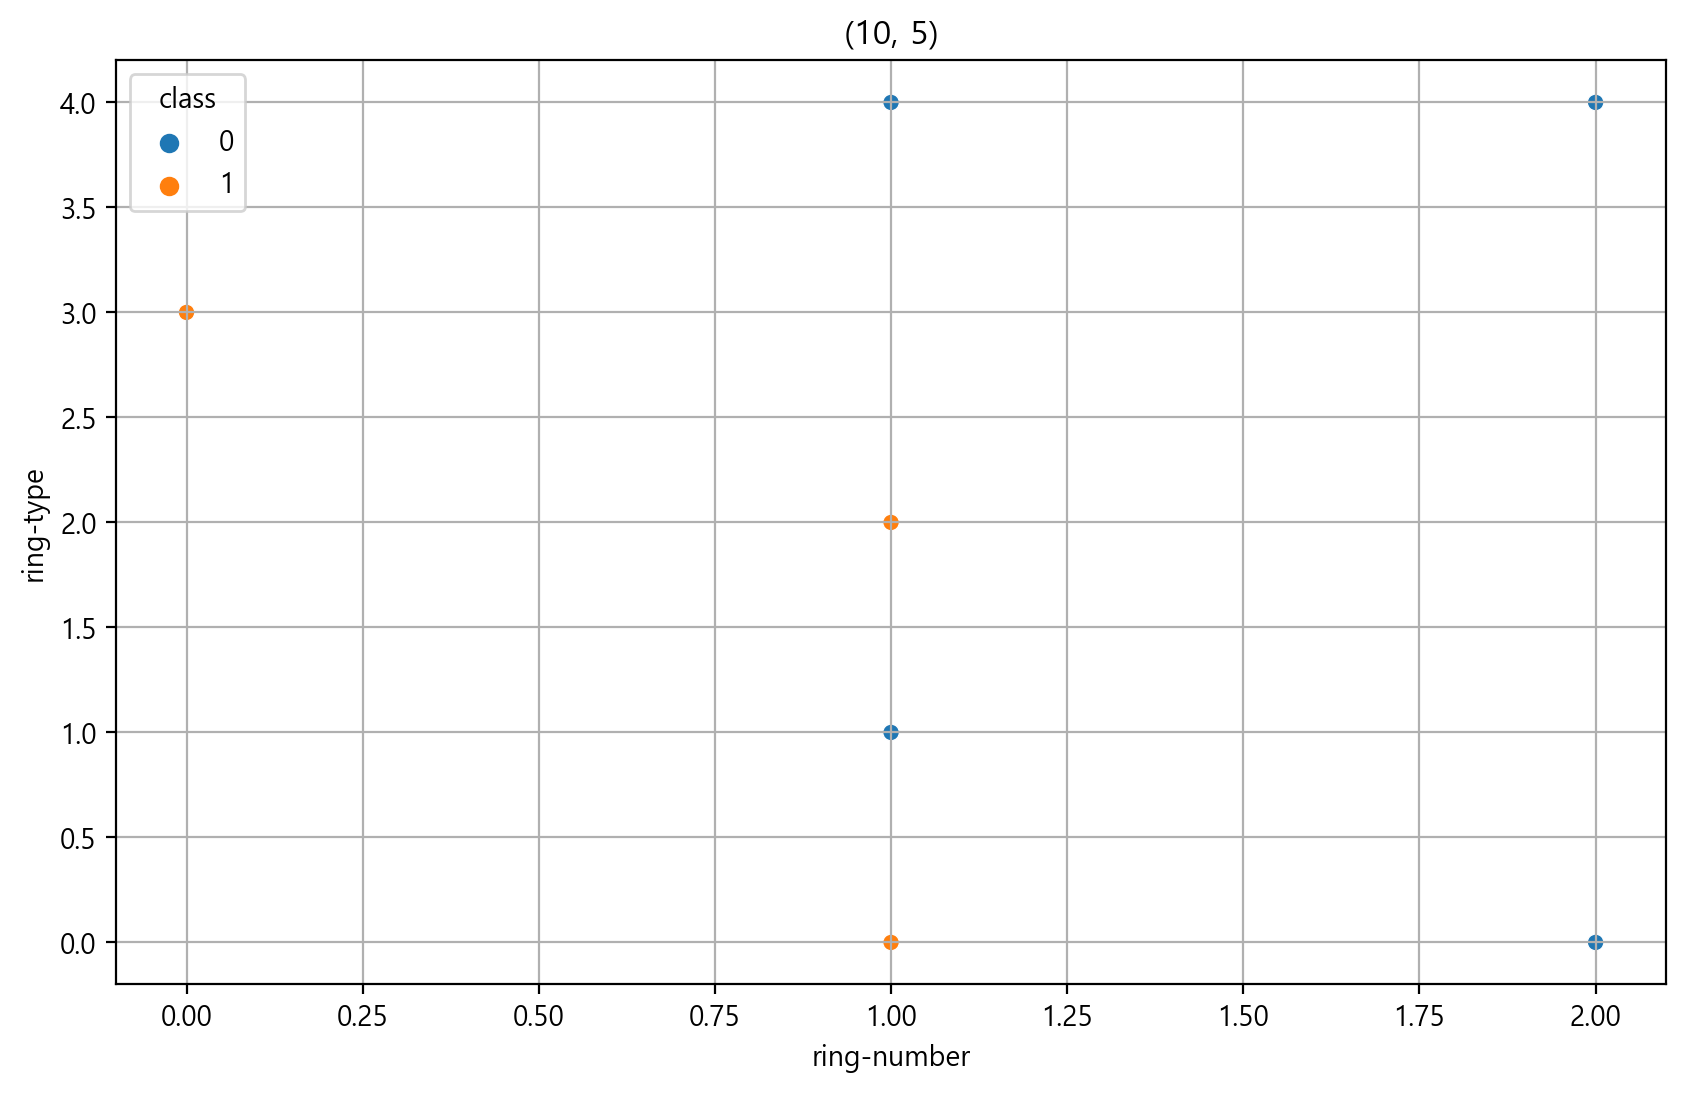

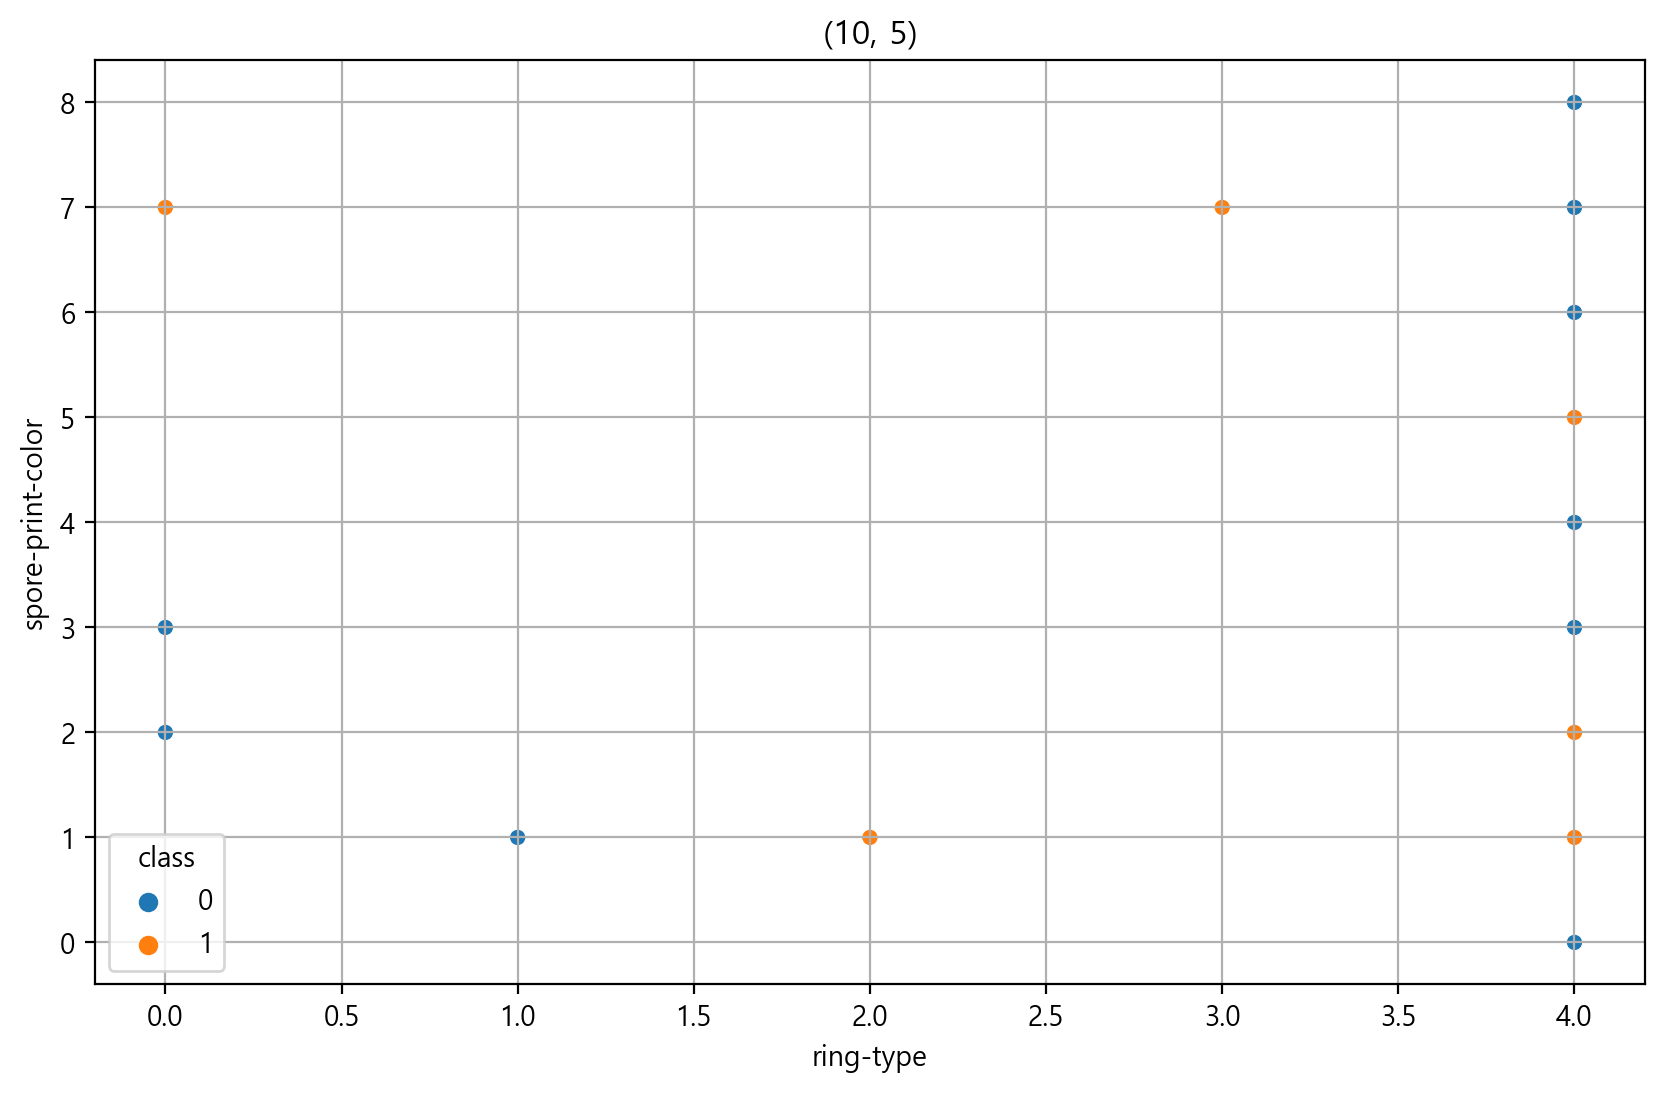

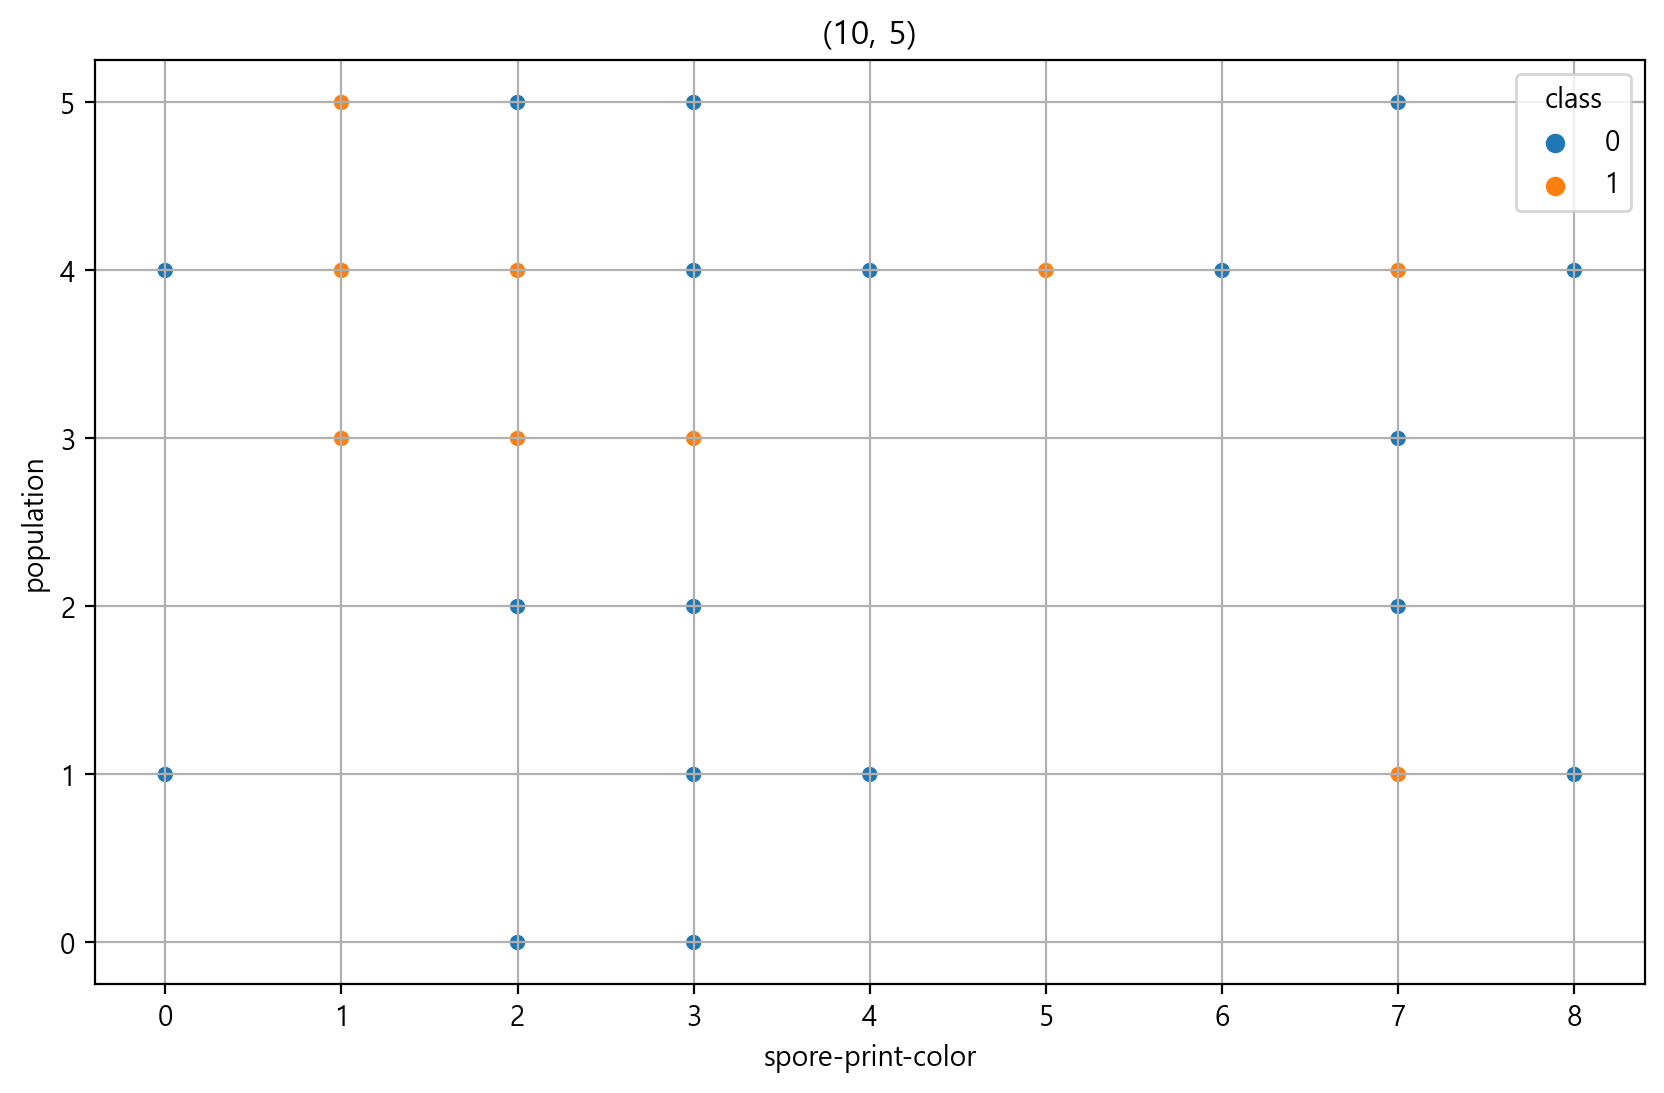

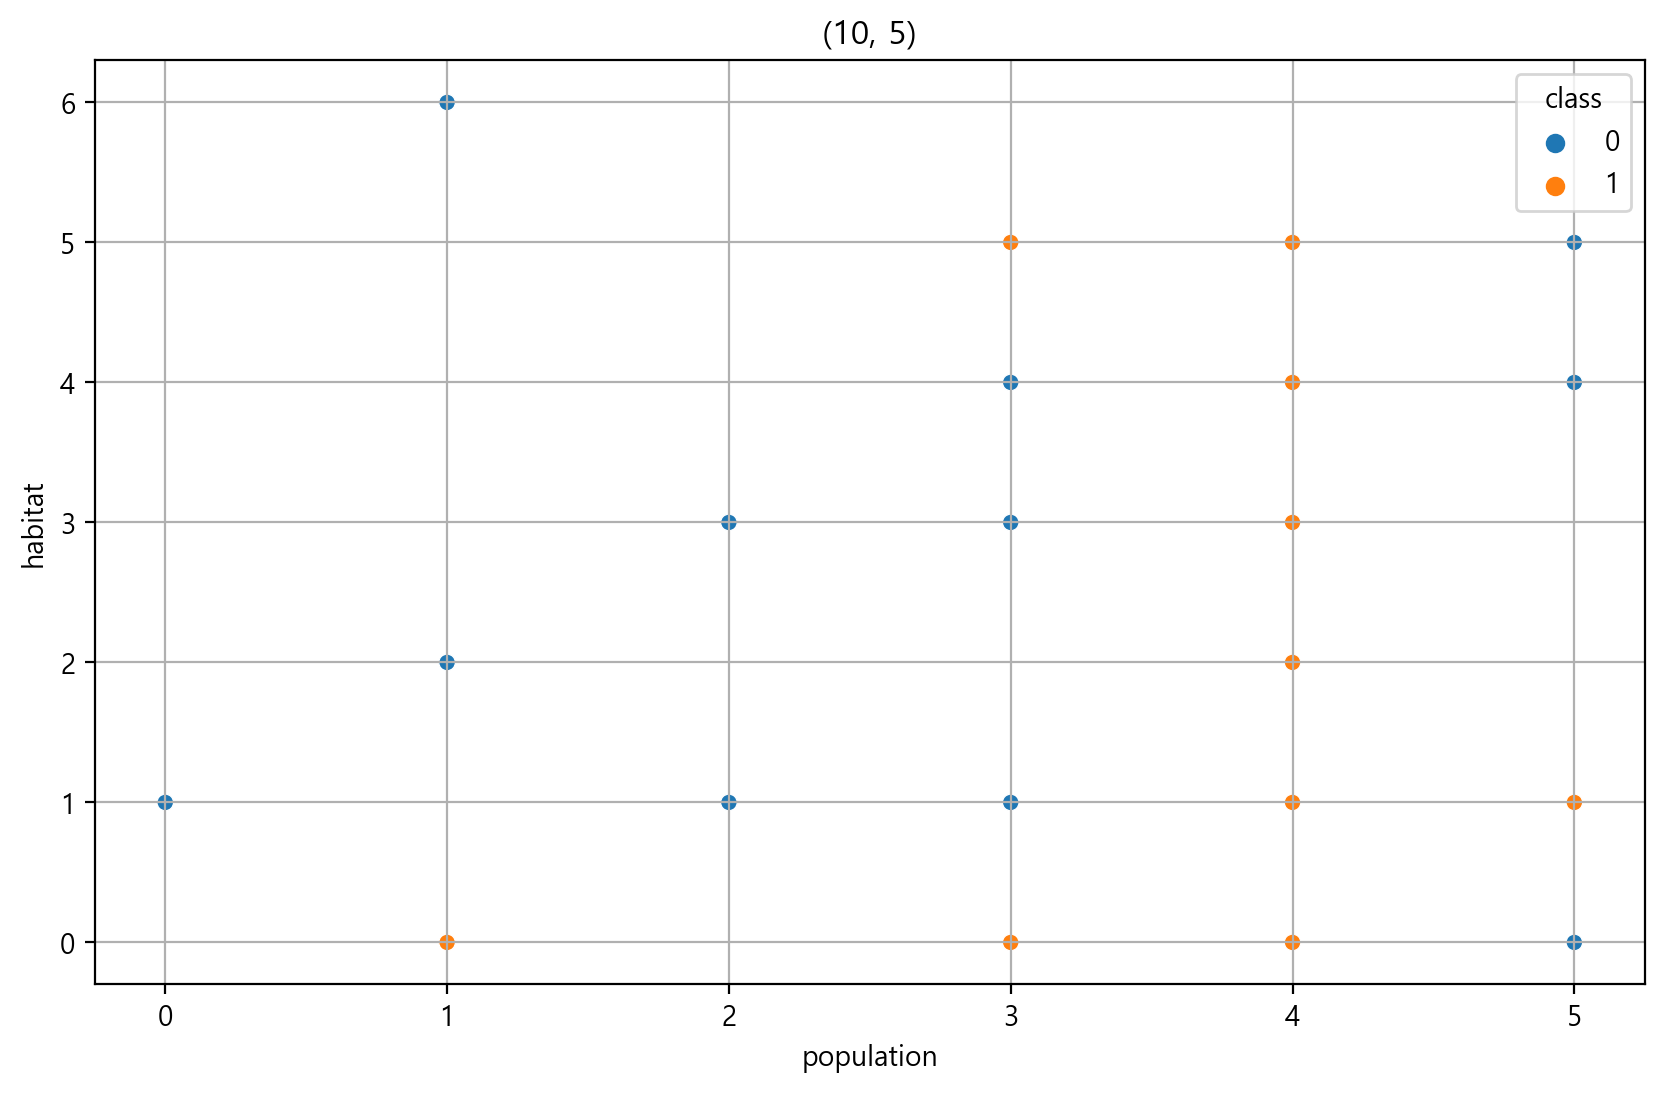

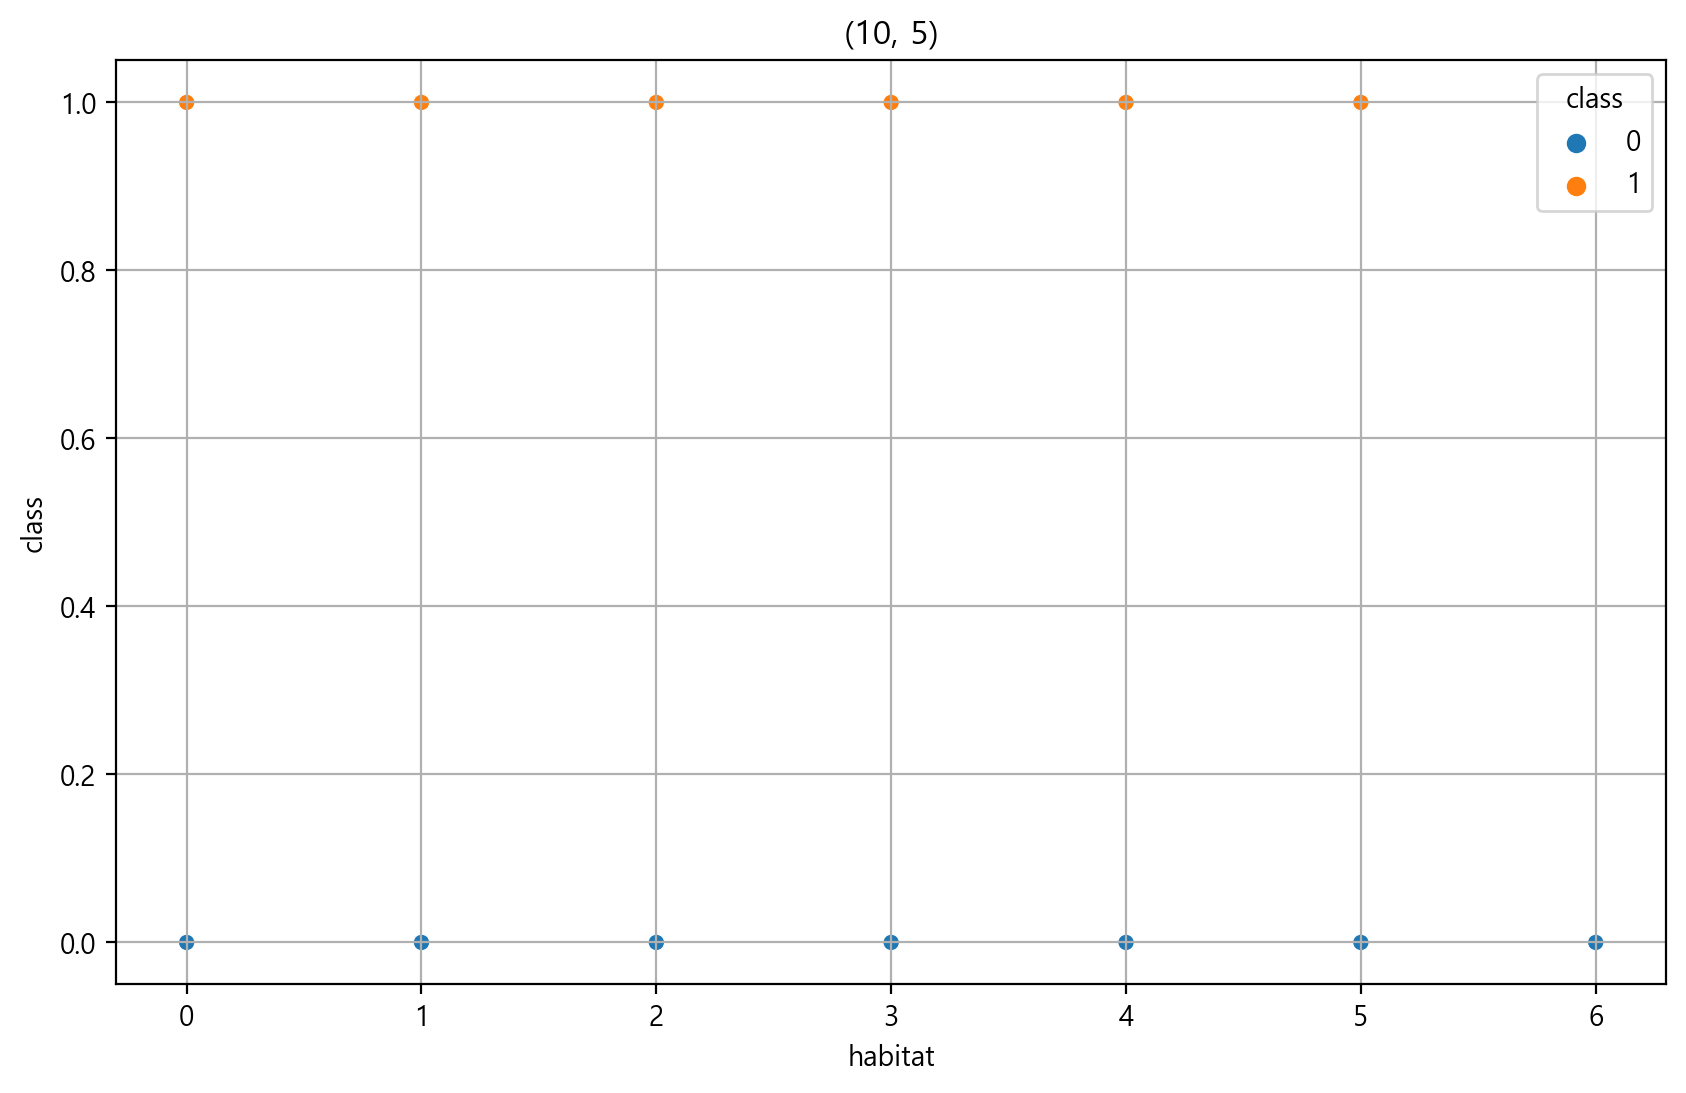

In [34]:
my_scatter_by_class(df,hue='class')

In [37]:
df2 = my_standard_scaler(df,'class')
df2.head()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,1.029712,0.140128,-0.198250,1.185917,0.881938,0.162896,-0.438864,1.494683,-0.228998,-1.144806,...,0.586385,0.622441,0.631991,0.142037,-0.256132,0.948081,-0.670195,-0.514389,2.030028,1
1,1.029712,0.140128,1.765874,1.185917,-1.970316,0.162896,-0.438864,-0.669038,-0.228998,-1.144806,...,0.586385,0.622441,0.631991,0.142037,-0.256132,0.948081,-0.250471,-1.313108,-0.295730,0
2,-2.087047,0.140128,1.373049,1.185917,-0.544189,0.162896,-0.438864,-0.669038,0.053477,-1.144806,...,0.586385,0.622441,0.631991,0.142037,-0.256132,0.948081,-0.250471,-1.313108,0.867149,0
3,1.029712,0.953270,1.373049,1.185917,0.881938,0.162896,-0.438864,1.494683,0.053477,-1.144806,...,0.586385,0.622441,0.631991,0.142037,-0.256132,0.948081,-0.670195,-0.514389,2.030028,1
4,1.029712,0.140128,-0.591075,-0.843230,0.406562,0.162896,2.278612,-0.669038,-0.228998,0.873511,...,0.586385,0.622441,0.631991,0.142037,-0.256132,-1.272216,-0.250471,-2.910546,-0.295730,0


In [38]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, yname='class')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6499, 21), (1625, 21), (6499,), (1625,))

In [39]:
# 스케일링 -> SVC, KNN 1
%%time
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |           0.906462 |            0.899215 |         0.901575 |           0.0892236 |      0.910776 |   0.900393 | 0.938316 |
| KNeighborsClassifier |                         0 |                  1 |                   1 |                1 |                   0 |             1 |          1 |        1 |
| LogisticRegression   |                  0.812623 |           0.964923 |      

In [40]:
x_train, x_test, y_train, y_test = my_train_test_split(df, yname='class')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6499, 21), (1625, 21), (6499,), (1625,))

In [42]:
%%time
my_classification(x_train, y_train, x_test, y_test)

<class 'sklearn.naive_bayes.GaussianNB'>는 n_jobs를 허용하지 않음
+----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                      |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|----------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| GaussianNB           |                         0 |           0.906462 |            0.899215 |         0.901575 |           0.0892236 |      0.910776 |   0.900393 | 0.938316 |
| KNeighborsClassifier |                         0 |                  1 |                   1 |                1 |                   0 |             1 |          1 |        1 |
| LogisticRegression   |                   0.81171 |           0.963077 |      